## Import

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import numpy as np
import os
from PIL import Image
from IPython import display
from IPython.display import Image
from pandas.plotting import table
from matplotlib.pyplot import cm
import scipy
from scipy.signal import find_peaks
from scipy import optimize
from scipy.sparse import csc_matrix, spdiags
from scipy import sparse
from scipy.sparse import linalg
import numpy as np
from numpy.linalg import norm
from BaselineRemoval import BaselineRemoval
# from colorspacious import cspace_converter

### Smoothing Import

In [17]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
#     r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
#     The Savitzky-Golay filter removes high frequency noise from data.
#     It has the advantage of preserving the original shape and
#     features of the signal better than other types of filtering
#     approaches, such as moving averages techniques.
#     Parameters
#     ----------
#     y : array_like, shape (N,)
#         the values of the time history of the signal.
#     window_size : int
#         the length of the window. Must be an odd integer number.
#     order : int
#         the order of the polynomial used in the filtering.
#         Must be less then `window_size` - 1.
#     deriv: int
#         the order of the derivative to compute (default = 0 means only smoothing)
#     Returns
#     -------
#     ys : ndarray, shape (N)
#         the smoothed signal (or it's n-th derivative).
#     Notes
#     -----
#     The Savitzky-Golay is a type of low-pass filter, particularly
#     suited for smoothing noisy data. The main idea behind this
#     approach is to make for each point a least-square fit with a
#     polynomial of high order over a odd-sized window centered at
#     the point.
#     Examples
#     --------
#     t = np.linspace(-4, 4, 500)
#     y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
#     ysg = savitzky_golay(y, window_size=31, order=4)
#     import matplotlib.pyplot as plt
#     plt.plot(t, y, label='Noisy signal')
#     plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
#     plt.plot(t, ysg, 'r', label='Filtered signal')
#     plt.legend()
#     plt.show()
#     References
#     ----------
#     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
#        Data by Simplified Least Squares Procedures. Analytical
#        Chemistry, 1964, 36 (8), pp 1627-1639.
#     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
#        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
#        Cambridge University Press ISBN-13: 9780521880688
#     """
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

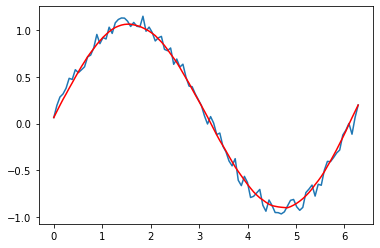

<Figure size 432x288 with 0 Axes>

In [18]:
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.figure()
plt.show()

In [19]:
import nbformat as nbf
from glob import glob

import uuid
def get_cell_id(id_length=8):
    return uuid.uuid4().hex[:id_length]

# your notebook name/keyword
nb_name = 'my_notebook'
notebooks = list(filter(lambda x: nb_name in x, glob("./*.ipynb", recursive=True)))

# iterate over notebooks
for ipath in sorted(notebooks):
    # load notebook
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)
    
    cell_ids = []
    for cell in ntbk.cells:
        cell_ids.append(cell['id'])

    # reset cell ids if there are duplicates
    if not len(cell_ids) == len(set(cell_ids)): 
        for cell in ntbk.cells:
            cell['id'] = get_cell_id()

        nbf.write(ntbk, ipath)

## Converting files extentions

In [179]:
# filenames_ZrO2 = glob.glob('C:/Users/CEVASIO/OneDrive/Python/HZO/ZrO2/ZrO2_TZVP_sp62_IR/*.irspec')

# for file in filenames:
#     base = os.path.splitext(file)[0]
#     os.rename(file, base + ".txt")

# filenames_txt = glob.glob('*.txt')

## ZrO2

In [180]:
filenames_ZrO2 = glob.glob('C:/Users/CEVASIO/OneDrive/Python/HZO/ZrO2/*.txt')
filenames_ZrO2.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

n = len(filenames_ZrO2)

fig, ax = plt.subplots(n,1)

d_ZrO2 = {}

colors = colors = ['purple', 'blue', 'green', 'magenta', 'orange', 'red', 'brown', 'black']
#cm.rainbow(np.linspace(0, 1, n))


for i, j, z in zip(filenames_ZrO2, colors, range(len(filenames_ZrO2))):
    #print(i)
    space_group = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    d_ZrO2[i[54:-14]] = space_group[["Frequency", "Raw_abs"]]
    if i[54:-14] == "14":
            phase = "monoclinic" + "\n" + "(14, P21/c)"
    if i[54:-14] == "11":
            phase = "monoclinic" + "\n" + "(11, P21/m)"
    if i[54:-14] == "2":
            phase = "triclinic" + "\n" + "(2, P-1)"
    if i[54:-14] == "61":
            phase = "orthorhombic" + "\n" + "(61, Pbca)"
    if i[54:-14] == "29":
            phase = "orthorhombic" + "\n" + "(29, Pca21)" + "\n" + "(ferroelectric) "
    if i[54:-14] == "62":
            phase = "orthorhombic" + "\n" + "(62, Pnma)"
    if i[54:-14] == "225":
            phase = "cubic" + "\n" + "(225, Fm3m)"
    if i[54:-14] == "137":
            phase = "tetragonal" + "\n" + "(137, P42/nmc)"
            
 
    ax[z].plot(space_group.Frequency[:800], space_group.Raw_abs[:800], linewidth=2, 
               label=(phase), 
               color=j)
    ax[0].set_title('ZrO$_2$', pad=15, fontsize = 17)
    ax[z].legend()  


fig.text(0.5, 0.08, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(8.5, 35.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# plt.show()
fig.savefig("ZrO2_DFT_IR.png", bbox_inches="tight")

AttributeError: 'function' object has no attribute 'glob'

In [ ]:
scipy.signal.find_peaks(d_ZrO2['225']['Raw_abs'])

In [ ]:
filenames_ZrO2 = glob.glob('C:/Users/CEVASIO/OneDrive/Python/HZO/ZrO2/*.txt')
filenames_ZrO2.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

n = len(filenames_ZrO2)

fig, ax = plt.subplots(n,1)

d_space_group = {}

colors = cm.rainbow(np.linspace(0, 1, n))


for i, j, z in zip(filenames_ZrO2, colors, range(len(filenames_ZrO2))):
    print(i)
    space_group = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    d_space_group[i] = space_group
    if i[54:-14] == "14":
            phase = "Monoclinic - most favorable at 300K - (space group P21/c - "
    if i[54:-14] == "11":
            phase = "Monoclinic (space group P21/m - "
    if i[54:-14] == "2":
            phase = "Triclinic (space group P-1 - "
    if i[54:-14] == "61":
            phase = "Orthorhombic (space group Pbca - "
    if i[54:-14] == "29_3":
            phase = "Orthorhombic - ferroelectric - (space group Pca21  - "
    if i[54:-14] == "62":
            phase = "Orthorhombic (space group Pnma - "
    if i[54:-14] == "225":
            phase = "Cubic (space group Fm3m - "
    if i[54:-14] == "137":
            phase = "tetragonal (space group P42/nmc - "
    
    ax[z].set_title(phase + i[54:-14] +')', pad=10)
    ax[z].plot(space_group.Frequency[:800], space_group.Classical_abs[:800], linewidth=2, 
               label=('Extinction Coefficient - Classical Absorption'), 
               color=j)
    ax[z].plot(space_group.Frequency[:800], space_group.Rayleigh_scat1[:800], linewidth=2, 
               label=('Rayleigh Scattering 1'), 
               color=j,
              linestyle=':')
    ax[z].plot(space_group.Frequency[:800], space_group.Rayleigh_scat2[:800], linewidth=2, 
               label=('Rayleigh Scattering 2'), 
               color=j,
              linestyle='--')
    
    ax[z].legend(bbox_to_anchor=(1, 1))  

fig.text(0.50, 0.92, 'ZrO$_2$', ha='center', va='center', fontsize = 20)
fig.text(0.5, 0.08, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(8.5, 35.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# plt.show()
# fig.savefig("ZrO2_K_DFT_IR.png", bbox_inches="tight")

In [ ]:
filenames_ZrO2 = glob.glob('C:/Users/CEVASIO/OneDrive/Python/HZO/ZrO2/*.txt')

n = len(filenames_ZrO2)

fig, ax = plt.subplots(n,1)

d_space_group = {}

colors = cm.rainbow(np.linspace(0, 1, n))


for i, j, z in zip(filenames_ZrO2, colors, range(len(filenames_ZrO2))):
    print(i)
    space_group = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    d_space_group[i] = space_group
    if i[54:-14] == "14":
            phase = "monoclinic P21/c(most favorable at 300K) "
    if i[54:-14] == "11":
            phase = "monoclinic P21/m "
    if i[54:-14] == "2":
            phase = "triclinic P-1"
    if i[54:-14] == "61":
            phase = "orthorhombic Pbca "
    if i[54:-14] == "29_3":
            phase = "orthorhombic Pca21" + "\n" + "(ferroelectric) "
    if i[54:-14] == "62":
            phase = "orthorhombic Pnma "
    if i[54:-14] == "225":
            phase = "cubic Fm3m "
    if i[54:-14] == "137":
            phase = "tetragonal P42/nmc "
            
    ax[z].plot(space_group.Frequency[:800], space_group.Reflec_x[:800], linewidth=2, 
               label=("Reflectance x"), 
               color=j)
    ax[z].plot(space_group.Frequency[:800], space_group.Reflec_y[:800], linewidth=2, 
               label=("Reflectance y"), 
               color=j, 
               linestyle='--') 
    ax[z].plot(space_group.Frequency[:800], space_group.Reflec_z[:800], linewidth=2, 
               label=("Reflectance z"), 
               color=j, 
               linestyle=':')     
    ax[0].set_title('ZrO$_2$', pad=15, fontsize = 17)
    ax[z].legend(title = phase + i[54:-14], bbox_to_anchor=(1, 1))  


fig.text(0.5, 0.05, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(8.5, 20.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# plt.show()
fig.savefig("ZrO2_DFT_R_IR.png", bbox_inches="tight")

## HfO2

In [ ]:
filenames_HfO2 = glob.glob('C:/Users/CEVASIO/OneDrive/Python/HZO/HfO2/Extract_data/IR/*.txt')
filenames_HfO2.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#print(filenames_HfO2)

n = len(filenames_HfO2)

fig, ax = plt.subplots(n,1)

d_HfO2 = {}

cmap = plt.get_cmap('hsv')

colors = ['purple', 'blue', 'green', 'magenta', 'orange', 'red', 'brown', 'black']
#cmap(np.linspace(0.2,1,n)) 
#cm.rainbow(np.linspace(0, 1, n))


for i, j, z in zip(filenames_HfO2, colors, range(len(filenames_HfO2))):
    #print(i)
    space_group = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    d_HfO2[i[65:-7]] = space_group[["Frequency", "Raw_abs"]]
    if i[65:-7] == "14":
            phase = "monoclinic" + "\n" + "(14, P21/c)"
    if i[65:-7] == "11":
            phase = "monoclinic" + "\n" + "(11, P21/m)"
    if i[65:-7] == "2":
            phase = "triclinic" + "\n" + "(2, P-1)"
    if i[65:-7] == "61":
            phase = "orthorhombic" + "\n" + "(61, Pbca)"
    if i[65:-7] == "29":
            phase = "orthorhombic" + "\n" + "(29, Pca21)" + "\n" + "(ferroelectric) "
    if i[65:-7] == "62":
            phase = "orthorhombic" + "\n" + "(62, Pnma)"
    if i[65:-7] == "225":
            phase = "cubic" + "\n" + "(225, Fm3m)"
    if i[65:-7] == "137":
            phase = "tetragonal" + "\n" + "(137, P42/nmc)"        
    ax[z].plot(space_group.Frequency[:800], space_group.Raw_abs[:800], linewidth=2, label=(phase), 
               color=j)
    ax[0].set_title('HfO$_2$', pad=15, fontsize = 17)
    ax[z].legend()  
#bbox_to_anchor=(1.5, 1)

fig.text(0.5, 0.08, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(8.5, 35.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# plt.show()
fig.savefig("HfO2_DFT_IR.png", bbox_inches="tight")

In [ ]:
scipy.signal.find_peaks(d_HfO2['137']['Raw_abs'])

## HZO different thickness Experimental

['HZO_10_RT.txt', 'HZO_11_RT.txt', 'HZO_17_RT.txt', 'HZO_21_RT.txt', 'HZO_23_RT.txt', 'HZO_52_RT.txt']
HZO_10_RT.txt norm
HZO_11_RT.txt norm
HZO_17_RT.txt norm
HZO_21_RT.txt norm
HZO_23_RT.txt norm
HZO_52_RT.txt not norm


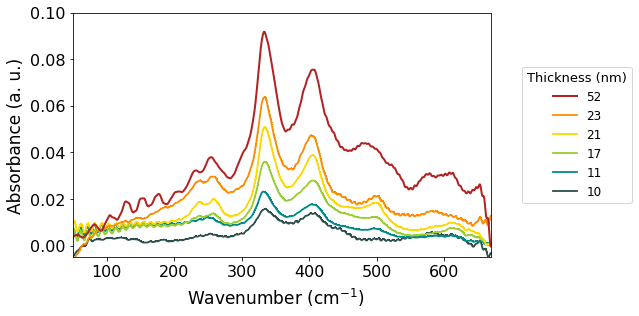

In [4]:
filenames_HfO2_exp = glob.glob('HZO*_RT.txt')
print(filenames_HfO2_exp)
filenames_HfO2_exp.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#print(filenames_HfO2)

n = len(filenames_HfO2_exp)

# fig, ax = plt.subplots(len(filenames_HfO2_exp),1)
fig, ax = plt.subplots()

d_HZO = {}
d_HZO_norm= {}

# cmap = plt.get_cmap('hsv')

colors = ['darkslategray', 'darkcyan', 'yellowgreen', 'gold', 'darkorange', 'firebrick']
# colors = cmap(np.linspace(0.2,1,n)) 
#cm.rainbow(np.linspace(0, 1, n))

for i, j, z in zip(filenames_HfO2_exp, colors, range(len(filenames_HfO2_exp))):

    space_group = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Absorbance"], header=None)
    d_HZO[i] = space_group
    
    #Put all absorbance postive (shift the curves)
    if i[4:6]  == '10':
        print(i, 'norm')
        I_min = space_group['Absorbance'][50:].min()
        I_pos = space_group['Absorbance']-(I_min+0.005)

        ax.plot(space_group.Frequency, I_pos, linewidth=1.8, label=i[4:6], 
                   color=j, marker=',')
    elif i[4:6] in ['11', '17', '21', '23']:
        print(i, 'norm')
        I_min = space_group['Absorbance'][50:].min()
        I_pos = space_group['Absorbance']-I_min

        ax.plot(space_group.Frequency, I_pos, linewidth=1.8, label=i[4:6], 
                   color=j, marker=',')
                
    elif i[4] == '6':
        print(i, 'not norm')
        ax.plot(space_group.Frequency, space_group.Absorbance, linewidth=2, label=i[4], 
                   color=j)
    else:
        print(i, 'not norm')
        ax.plot(space_group.Frequency, space_group.Absorbance, linewidth=2, label=i[4:6], 
                   color=j)    
        
#get handles and labels
handles, labels = ax.get_legend_handles_labels()

#specify order of items in legend
order = sorted(range(0, n), reverse=True)

    #add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
          loc='right', bbox_to_anchor=(1.35, 0.5), title = "Thickness (nm)", fontsize = 12, title_fontsize=13)
# ax.legend(bbox_to_anchor=(1.22,0.5), loc='center right')
    
# bbox_to_anchor=(1.5, 1)
ax.set_ylim(-0.005, 0.1)
ax.set_xlim(50, 670)


fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(7.5, 4.5)

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)

# fig.savefig("Fig_Thickness.png", bbox_inches="tight")

In [25]:
from scipy.signal import find_peaks

In [26]:
find_peaks(d_HZO['HZO_11_RT.txt'].Absorbance)

(array([   2,   24,   45,   66,   88,  110,  131,  153,  174,  196,  217,
         238,  260,  281,  303,  324,  346,  368,  389,  410,  433,  448,
         493,  517,  541,  607,  754,  855,  918,  946,  960, 1021, 1050,
        1068, 1094, 1113, 1136, 1154, 1184, 1197, 1212, 1244, 1261, 1276,
        1293], dtype=int64),
 {})

In [27]:
d_HZO['HZO_11_RT.txt'].Absorbance

0      -0.00373
1      -0.00344
2      -0.00333
3      -0.00340
4      -0.00363
         ...   
1304   -0.00743
1305   -0.00727
1306   -0.00707
1307   -0.00685
1308   -0.00665
Name: Absorbance, Length: 1309, dtype: float64

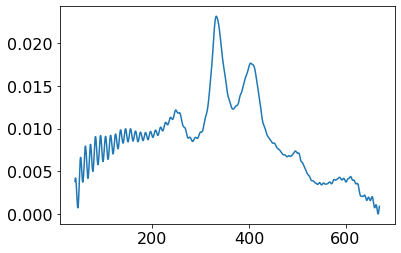

In [28]:
I_min = d_HZO['HZO_11_RT.txt'].Absorbance[50:].min()
I_pos = d_HZO['HZO_11_RT.txt'].Absorbance-I_min

# find_peaks(I_pos, threshold=0.00001, width=5)
plt.plot(d_HZO['HZO_11_RT.txt'].Frequency, I_pos)

In [29]:
d_HZO['HZO_23_RT.txt'].Absorbance

0      -0.024157
1      -0.025104
2      -0.025652
3      -0.025920
4      -0.025940
          ...   
1305    0.008298
1306    0.008540
1307    0.008561
1308    0.008362
1309    0.007994
Name: Absorbance, Length: 1310, dtype: float64

In [30]:
d_HZO['HZO_23_RT.txt'].Frequency

0        39.533619
1        40.015739
2        40.497849
3        40.979969
4        41.462090
           ...    
1305    668.696720
1306    669.178830
1307    669.660950
1308    670.143070
1309    670.625180
Name: Frequency, Length: 1310, dtype: float64

## Other treatments

In [ ]:
from scipy.signal import find_peaks

d_HZO['HZO_10_RT.txt'].Frequency[(find_peaks(d_HZO['HZO_10_RT.txt'].Absorbance))[0]]

In [ ]:


with open("HZO_11_norm.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm['HZO_11.txt'], delimiter=' ', newline='\n')

In [ ]:
with open("HZO_17_norm.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm['HZO_17.txt'][::2], delimiter=' ', newline='\n')

In [ ]:
with open("HZO_21_norm.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm['HZO_21.txt'], delimiter=' ', newline='\n')

In [ ]:
d_HZO_norm_T = {}
for keys in d_HZO_norm.keys():
#     print(keys)
    T = 10**(-d_HZO_norm[keys][:, 1])
#     print(d_HZO_norm[keys][:, 1], T)
#     print(d_HZO_norm[keys][:,0].shape)
    T_freq = np.concatenate((d_HZO_norm[keys][:,0].reshape(1309,1),T.reshape(1309,1)), axis=1)
#     print(T_freq)
    d_HZO_norm_T[keys] = T_freq
#     print(d_HZO_norm_T)
    plt.plot(d_HZO_norm_T[keys][:,0], d_HZO_norm_T[keys][:, 1])
    



In [ ]:
d_HZO_norm_T

In [ ]:
with open("d_HZO_21_norm_T.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm_T['HZO_11.txt'], delimiter=' ', newline='\n')

In [ ]:
with open("d_HZO_17_norm_T.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm_T['HZO_17.txt'][::2], delimiter=' ', newline='\n')

In [ ]:
with open("d_HZO_11_norm_T.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm_T['HZO_21.txt'], delimiter=' ', newline='\n')

In [ ]:


with open("HZO_11_norm.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm['HZO_11.txt'], delimiter=' ', newline='\n')

with open("HZO_17_norm.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm['HZO_17.txt'][::2], delimiter=' ', newline='\n')

with open("HZO_21_norm.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm['HZO_21.txt'], delimiter=' ', newline='\n')

d_HZO_norm_T = {}
for keys in d_HZO_norm.keys():
#     print(keys)
    T = 10**(-d_HZO_norm[keys][:, 1])
#     print(d_HZO_norm[keys][:, 1], T)
#     print(d_HZO_norm[keys][:,0].shape)
    T_freq = np.concatenate((d_HZO_norm[keys][:,0].reshape(1309,1),T.reshape(1309,1)), axis=1)
#     print(T_freq)
    d_HZO_norm_T[keys] = T_freq
#     print(d_HZO_norm_T)
    plt.plot(d_HZO_norm_T[keys][:,0], d_HZO_norm_T[keys][:, 1])
    



d_HZO_norm_T

with open("d_HZO_21_norm_T.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm_T['HZO_11.txt'], delimiter=' ', newline='\n')

with open("d_HZO_17_norm_T.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm_T['HZO_17.txt'][::2], delimiter=' ', newline='\n')

with open("d_HZO_11_norm_T.txt", 'w') as txt:
    np.savetxt(txt, d_HZO_norm_T['HZO_21.txt'], delimiter=' ', newline='\n')    #     #Normalise to 1
    #     I_max = I_pos.max()
    # #     print(I_max)
    #     I_norm = (I_pos)/(I_max)

    #     print(np.array(I_norm).reshape(1309,1).shape)
    #     print(np.array(space_group['Frequency']).reshape(1309,1).shape)
    #     print('array size is ', np.array(space_group['Frequency']).shape)
    #     print(space_group['Frequency'])

    #     #Save to a dictionary all data normalised and shifted
    #     d_HZO_norm[i] = np.concatenate((np.array(space_group['Frequency']).reshape(1309,1),
    #                                     np.array(I_norm).reshape(1309,1)), axis=1)


        #Plot data
    #     ax.plot(space_group.Frequency, space_group.Absorbance, linewidth=2, label=(i), 
    #                color=j)

## High-T Measurements

## 21 nm

#### Converting files to txt and renaming

In [ ]:
# filenames_HZO21_high_T = glob.glob('High_T/21nm/Si/*')

# n = range(0, len(filenames_HZO21_high_T))
# # print(n)

# for file, number in zip(filenames_HZO21_high_T, n):
#     base = os.path.splitext(file)[0]
#     print(base)
# #     print(number)
#     os.rename(file, 'High_T/21nm/Si/' + str(number) + ".txt")

# # filenames_HZO21_high_T_txt = glob.glob('*.txt')

#### Plotting and Treating

In [ ]:
def txt_to_dic(address):
    dic_name={}
    filenames = glob.glob(address)
    filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    for i in filenames:
        measurement = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Absorbance"], header=None)
        dic_name[i] = measurement
    return dic_name

In [ ]:
dic_Si = txt_to_dic('High_T/21nm/Si/*')

In [ ]:
dic_HZO21 = txt_to_dic('High_T/21nm/HZO21/*')

In [ ]:
dic_HZO21[r'High_T/21nm/HZO21\0.txt'].Absorbance.shape

In [ ]:
dic_Si[r'High_T/21nm/Si\0.txt'].Frequency[::-1]

In [ ]:
dic_AbsHZO21_old = {}

for i, j in zip(dic_Si.keys(), dic_HZO21.keys()):
    
    I_HZO21 = -np.log(dic_HZO21[j].Absorbance[::-1]/dic_Si[i].Absorbance[::-1])
    wvn = dic_HZO21[r'High_T/21nm/HZO21\0.txt'].Frequency[::-1]

    dic_AbsHZO21_old[j] = pd.concat([wvn[75:], I_HZO21[75:]], axis=1)
#     print(dic_AbsHZO21)

In [ ]:
np.savetxt("HZOHighT_0.txt", dic_AbsHZO21['High_T/21nm/HZO21\\0.txt'],
           delimiter=" ")

In [ ]:
n = [24, 42, 59, 76, 93, 111, 127, 143, 161, 178, 195, 212, 229, 247, 
     264, 280, 298, 315, 330, 347, 364, 381, 397, 413, 431, 448, 463, 482 ]
print(len(n))
n_Kelvin = []
for i in n:
    n_Kelvin.append(i+273)
print(str(n_Kelvin))
print(len(n_Kelvin))

In [ ]:
len(dic_AbsHZO21)

In [ ]:
dic_AbsHZO21 = {}

for k, v, temp in zip(dic_AbsHZO21_old.keys(), dic_AbsHZO21_old.values(), n_Kelvin):
#     print(k, v, temp)
    dic_AbsHZO21[str(temp)] = v
print(dic_AbsHZO21)

In [ ]:
dic_AbsHZO21.keys()

### Baseline treatment

In [ ]:
x = dic_AbsHZO21['297'].Frequency
y1 = dic_AbsHZO21['297'].Absorbance

plt.plot(x, y1)

#Polynomial of second degree
def f(x, a, b, c, d):
	return a * x**3  + b * x**2 + c * x + d

params, params_cov = optimize.curve_fit(f, x, y1)

test = y1-(f(x, params[0], params[1],params[2], params[3]))

plt.plot(x, test)
plt.plot(x, f(x, params[0], params[1],params[2], params[3]))

In [ ]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = scipy.sparse.linalg.spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z


# works perfectly for me. just quoting from that paper what those parameters are:
# <<There are two parameters: p for asymmetry and λ for smoothness. Both have to be
# tuned to the data at hand. We found that generally 0.001 ≤ p ≤ 0.1 is a good choice 
# (for a signal with positive peaks) and 10^2 ≤ λ ≤ 10^9 , but exceptions may occur.
# In any case one should vary λ on a grid that is approximately linear for log λ>> – 


In [ ]:
z = baseline_als(y1, 10^2, 0.1)

x = dic_AbsHZO21['297'].Frequency
y1 = dic_AbsHZO21['297'].Absorbance

plt.plot(x, y1)

#Polynomial of second degree
def f(x, a, b, c, d):
	return a * x**3  + b * x**2 + c * x + d

params, params_cov = optimize.curve_fit(f, x, y1)

test = y1-(f(x, params[0], params[1],params[2], params[3]))

plt.plot(x, test)
plt.plot(x, f(x, params[0], params[1],params[2], params[3]))
plt.plot(x, z, c='red')

In [ ]:
def baseline_als(y, lam, p, niter=10):                                                                        

    s  = len(y)                                                                                               
    # assemble difference matrix                                                                              
    D0 = sparse.eye( s )                                                                                      
    d1 = [np.ones( s-1 ) * -2]                                                                             
    D1 = sparse.diags( d1, [-1] )                                                                             
    d2 = [ np.ones( s-2 ) * 1]                                                                             
    D2 = sparse.diags( d2, [-2] )                                                                             

    D  = D0 + D2 + D1                                                                                         
    w  = np.ones( s )                                                                                         
    for i in range( niter ):                                                                                  
        W = sparse.diags( [w], [0] )                                                                          
        Z =  W + lam*D.dot( D.transpose() )                                                                   
        z = scipy.sparse.linalg.spsolve( Z, w*y )                                                                                 
        w = p * (y > z) + (1-p) * (y < z)                                                                     

    return z

In [ ]:
x[30:500]

In [ ]:
z = baseline_als(y1, 10^2, 0.1)

x = dic_AbsHZO21['297'].Frequency
y1 = dic_AbsHZO21['297'].Absorbance

plt.plot(x, y1)

#Polynomial of 3rd degree
def f(x, a, b, c, d):
	return a * x**3  + b * x**2 + c * x + d

params, params_cov = optimize.curve_fit(f, x, y1)

background = (f(x, params[0], params[1],params[2], params[3]))-0.02

test = y1-(f(x, params[0], params[1],params[2], params[3]))
test_2= y1-background

plt.plot(x, test)
plt.plot(x, f(x, params[0], params[1],params[2], params[3]))
plt.plot(x, background, c='magenta')
plt.plot(x, test_2, c='magenta')
plt.plot(x, z, c='red')

In [ ]:
z = baseline_als(y1, 10^2, 0.1)

x = dic_AbsHZO21['297'].Frequency
y1 = dic_AbsHZO21['297'].Absorbance

plt.plot(x, y1)

#Polynomial of 4th degree
def f(x, a, b, c, d, e):
	return a * x**4  + b * x**3 + c * x**2 + d *x + e

params, params_cov = optimize.curve_fit(f, x, y1)

background = (f(x, params[0], params[1],params[2], params[3], params[4]))-0.02

test = y1-(f(x, params[0], params[1],params[2], params[3], params[4]))
test_2= y1-background

plt.plot(x, test)
plt.plot(x, f(x, params[0], params[1],params[2], params[3], params[4]))
plt.plot(x, background, c='magenta')
plt.plot(x, test_2, c='magenta')
plt.plot(x, z, c='red')

In [ ]:
def baseline_arPLS(y, ratio=1e-6, lam=100, niter=10, full_output=False):
    L = len(y)

    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)

    H = lam * D.dot(D.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252

    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)

    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return z, d, info
    else:
        return z

In [ ]:
z = baseline_arPLS(y1, ratio=0.1, lam=1)

x = dic_AbsHZO21['297'].Frequency
y1 = dic_AbsHZO21['297'].Absorbance

plt.plot(x, y1)

#Polynomial of second degree
def f(x, a, b, c, d):
	return a * x**3  + b * x**2 + c * x + d

params, params_cov = optimize.curve_fit(f, x, y1)

test = y1-(f(x, params[0], params[1],params[2], params[3]))

plt.plot(x, test)
plt.plot(x, f(x, params[0], params[1],params[2], params[3]))
plt.plot(x, z, c='red')

### BaselineRemoval package

In [ ]:
input_array=[10,20,1.5,5,2,9,99,25,47]

polynomial_degree=2 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(input_array)

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

print('Original input:',input_array)

print('Modpoly base corrected values:',Modpoly_output)

print('IModPoly base corrected values:',Imodpoly_output)

print('ZhangFit base corrected values:',Zhangfit_output)

# Original input: [10, 20, 1.5, 5, 2, 9, 99, 25, 47]

# Modpoly base corrected values: [-1.98455800e-04  1.61793368e+01  1.08455179e+00  5.21544654e+00
#   7.20210508e-02  2.15427531e+00  8.44622093e+01 -4.17691125e-03
#   8.75511661e+00]

# IModPoly base corrected values: [-0.84912125 15.13786196 -0.11351367  3.89675187 -1.33134142  0.70220645
#  82.99739548 -1.44577432  7.37269705]

# ZhangFit base corrected values: [ 8.49924691e+00  1.84994576e+01 -3.31739230e-04  3.49854060e+00
#   4.97412948e-01  7.49628529e+00  9.74951576e+01  2.34940300e+01
#   4.54929023e+01

In [ ]:
x = dic_AbsHZO21['297'].Frequency
y1 = dic_AbsHZO21['297'].Absorbance

start = 0

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(y1[start:])

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(x, y1)
plt.plot(x[start:], Modpoly_output, c='orange')
plt.plot(x[start:], Imodpoly_output, c='red')
plt.plot(x[start:], Zhangfit_output, c='green')

In [ ]:
x[0:120]

In [ ]:
# 2eme baseline correction

x = dic_AbsHZO21['297'].Frequency
y1 = Modpoly_output

start = 0
end = 150

polynomial_degree=4 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(y1[start:end])

Modpoly_output_2=baseObj.ModPoly(polynomial_degree)

Imodpoly_output_2=baseObj.IModPoly(polynomial_degree)

Zhangfit_output_2=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(x[start:end], y1[start:end])
plt.plot(x[start:end], Modpoly_output_2, c='orange')
plt.plot(x[start:end], Imodpoly_output_2, c='red')
plt.plot(x[start:end], Zhangfit_output_2, c='green')

In [ ]:
test = np.concatenate((Imodpoly_output_2, Modpoly_output[end:]), axis=0)
test.shape
plt.plot(x, test)

### Plotting

### Original

In [ ]:
n = len(dic_AbsHZO21)
# print(n)

fig, ax = plt.subplots()

cmap = plt.get_cmap('hsv')
colors = cmap(np.linspace(0.2,1,n)) 
# print(colors)


for i, j in zip(dic_AbsHZO21.keys(), colors):
#     print(i)
    ax.plot(dic_AbsHZO21[i].Frequency, dic_AbsHZO21[i].Absorbance, label=i, c=j)
    ax.legend(ncol=2, bbox_to_anchor=(1,1))
    ax.set_ylim(-0.25, 0.1)
    
    
    
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

### Just a Polynomial correction

In [ ]:
dic_AbsHZO21['297']["Frequency"].shape

In [ ]:
n = len(dic_AbsHZO21)
# print(n)

fig, ax = plt.subplots()

cmap = plt.get_cmap('hsv')
# colors = cmap(np.linspace(0,1,n)) 
colors = cm.rainbow(np.linspace(0, 1, n))
# colors = plt.cm.get_cmap("jet")
# print(colors)


#Polynomial of 3rd degree
def f(x, a, b, c, d):
	return a * x**3  + b * x**2 + c * x + d



# background = (f(x, params[0], params[1],params[2], params[3]))-0.02

# test = y1-(f(x, params[0], params[1],params[2], params[3]))
# test_2= y1-background

dic_AbsHZO21_baseline_cor = {}

for i, j in zip(dic_AbsHZO21.keys(), colors):
#     print(i)
    
    params, params_cov = optimize.curve_fit(f, dic_AbsHZO21[i]["Frequency"], dic_AbsHZO21[i]["Absorbance"])
    
    test = dic_AbsHZO21[i]["Absorbance"]-(f(dic_AbsHZO21[i].Frequency, params[0], params[1],params[2], params[3]))+0.02
    
#     ax.plot(dic_AbsHZO21[i].Frequency, dic_AbsHZO21[i].Absorbance, label=i[18:20], c=j)
    ax.plot(dic_AbsHZO21[i].Frequency, test, label=i, c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=(1.4 ,0.5), loc='right')
    ax.set_ylim(-0.01, 0.1)
    ax.set_xlim(80, 650)
    
    dic_AbsHZO21_baseline_cor[i] = np.concatenate((np.array(dic_AbsHZO21[i]["Frequency"]).reshape(609,1), 
                                                   np.array(test).reshape(609,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
list(dic_AbsHZO21_baseline_cor.keys())

In [ ]:
list_keys = np.array(list(dic_AbsHZO21_baseline_cor.keys()))

list_keys.shape

In [ ]:
list_keys[::2]

In [ ]:
np.linspace(0.3, 0.4, 28)

In [ ]:
n = len(dic_AbsHZO21_baseline_cor)

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

shifts = np.linspace(0, 0.12, 28)

for i, j, z in zip(dic_AbsHZO21_baseline_cor.keys(), colors, shifts):
    shited = dic_AbsHZO21_baseline_cor[i][:,1] + z
    
    
    ax.plot(dic_AbsHZO21_baseline_cor[i][:,0], shited, label=i, c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=(1.4,0.5), loc='right')
    ax.set_ylim(-0.005, 0.2)
    ax.set_xlim(80, 650)
    
#     dic_AbsHZO21_baseline_cor[i] = np.concatenate((np.array(dic_AbsHZO21[i]["Frequency"]).reshape(609,1), 
#                                                    np.array(test).reshape(609,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
list_keys = np.array(list(dic_AbsHZO21_baseline_cor.keys()))

start = 0
end = len(list_keys)
step = 2

n = len(list_keys[start:end:step])

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

shifts = np.linspace(0, 0.12, 28)

for i, j, z in zip(list_keys[start:end:step], colors, shifts):
    shited = dic_AbsHZO21_baseline_cor[i][:,1] + z
    
    
    ax.plot(dic_AbsHZO21_baseline_cor[i][:,0], shited, label=i, c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=(1.4,0.5), loc='right')
    ax.set_ylim(-0.005, 0.130)
    ax.set_xlim(80, 650)
    
#     dic_AbsHZO21_baseline_cor[i] = np.concatenate((np.array(dic_AbsHZO21[i]["Frequency"]).reshape(609,1), 
#                                                    np.array(test).reshape(609,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)


### BaselineRemoval code

In [ ]:
polynomial_degree=4 #only needed for Modpoly and IModPoly algorithm


n = len(dic_AbsHZO21)

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))


dic_AbsHZO21_BaselineRemoval = {}

for i, j in zip(dic_AbsHZO21.keys(), colors):
#     print(i)
    baseObj=BaselineRemoval(dic_AbsHZO21[i]["Absorbance"])
    Modpoly_output=baseObj.ModPoly(polynomial_degree)
    
#     ax.plot(dic_AbsHZO21[i].Frequency, dic_AbsHZO21[i].Absorbance, label=i[18:20], c=j)
    ax.plot(dic_AbsHZO21[i].Frequency, Modpoly_output, label=i, c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
    ax.set_ylim(-0.01, 0.1)
    ax.set_xlim(80, 650)
    
    dic_AbsHZO21_BaselineRemoval[i] = np.concatenate((np.array(dic_AbsHZO21[i]["Frequency"]).reshape(609,1), 
                                                   np.array(Modpoly_output).reshape(609,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)


In [ ]:
# dic_AbsHZO21_BaselineRemoval['High_T/21nm/HZO21\\0.txt'][150:,1]

In [ ]:

polynomial_degree=6 #only needed for Modpoly and IModPoly algorithm

n = n = len(dic_AbsHZO21_BaselineRemoval)

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

dic_AbsHZO21_BaselineRemoval_final = {}

start = 0
end = 150

for i, j in zip(dic_AbsHZO21_BaselineRemoval.keys(), colors):
#     print(i)
    baseObj=BaselineRemoval(dic_AbsHZO21_BaselineRemoval[i][start:end, 1])   
    Imodpoly_output_2=baseObj.IModPoly(polynomial_degree)
    
    final_BL_cor = np.concatenate((Imodpoly_output_2, dic_AbsHZO21_BaselineRemoval[i][end:, 1]), axis=0)
    
#     ax.plot(dic_AbsHZO21[i].Frequency, dic_AbsHZO21[i].Absorbance, label=i[18:20], c=j)
    ax.plot(dic_AbsHZO21[i].Frequency, final_BL_cor, label=i, c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
    ax.set_ylim(-0.01, 0.1)
    ax.set_xlim(80, 650)
    
    dic_AbsHZO21_BaselineRemoval_final[i] = np.concatenate((np.array(dic_AbsHZO21[i]["Frequency"]).reshape(609,1), 
                                                   np.array(final_BL_cor).reshape(609,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
list_keys = np.array(list(dic_AbsHZO21_BaselineRemoval_final.keys()))

start = 0
end = len(list_keys)
step = 2

n = len(list_keys[start:end:step])

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0.35, 1, n))

shifts = np.linspace(0, 0.12, 28)

for i, j, z in zip(list_keys[start:end:step], colors, shifts):
    shited = dic_AbsHZO21_BaselineRemoval_final[i][:,1] + z
    
    
    ax.plot(dic_AbsHZO21_BaselineRemoval_final[i][:,0], shited, label=i, c=j, linewidth=2)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              title = "Temperature (K)", ncol=1, loc='right', bbox_to_anchor=(1.35, 0.45), fontsize = 12, title_fontsize=13)
    
    ax.set_ylim(-0.008, 0.120)
    ax.set_xlim(80, 650)
    
#     , bbox_to_anchor=(1,0.35)
#     dic_AbsHZO21_baseline_cor[i] = np.concatenate((np.array(dic_AbsHZO21[i]["Frequency"]).reshape(609,1), 
#                                                    np.array(test).reshape(609,1)), axis=1)
    
fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Arbitrary Units', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(7.5, 4.5)

fig.savefig("Fig_HighT_21nm.png", bbox_inches="tight")

In [ ]:
# dic_AbsHZO21_BaselineRemoval_final

## 10nm

In [ ]:
# filenames_HZO10_high_T = glob.glob('High_T/10nm/*')

# n = range(0, len(filenames_HZO10_high_T))
# # print(n)

# for file, number in zip(filenames_HZO10_high_T, n):
#     base = os.path.splitext(file)[0]
#     print(base)
# #     print(number)
#     os.rename(file, 'High_T/10nm/' + str(number) + ".txt")

# # filenames_HZO21_high_T_txt = glob.glob('*.txt')

In [ ]:
# filenames_HZO10_high_T = glob.glob('High_T/10nm/*')
# filenames_HZO10_high_T.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# # len(filenames_HZO10_high_T)

In [ ]:
n = [24, 43, 60, 76, 94, 111, 128, 144, 161, 178, 195, 212, 231, 248, 
     265, 280, 296, 313, 347, 363, 380, 397, 414, 431, 448]
# print(len(n))

n_Kelvin = []
for i in n:
    n_Kelvin.append(i+273)
print(n_Kelvin)
print(len(n_Kelvin))

In [ ]:
# for file, number in zip(filenames_HZO10_high_T, n_Kelvin):
#     base = os.path.splitext(file)[0]
#     print(base)
#     print(number)
#     os.rename(file, 'High_T/10nm/' + str(number) + ".txt")

In [ ]:
dic_HZO10_HighT = txt_to_dic('High_T/10nm/*')

In [ ]:
len(dic_HZO10_HighT['High_T/10nm\\297.txt'].Frequency[225:2800])

In [ ]:
n = len(dic_HZO10_HighT)

fig, ax = plt.subplots()

start = 225
end = 2800

colors = cm.rainbow(np.linspace(0, 1, n))

dic_HZO10_HighT_cut= {}

for i, j in zip(dic_HZO10_HighT.keys(), colors):
#     print(i)
    ax.plot(dic_HZO10_HighT[i].Frequency[start:end], dic_HZO10_HighT[i].Absorbance[start:end], label=i[12:-4], c=j)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
#     ax.set_ylim(-0.15, 0.2)
#     ax.set_xlim(50, 650)

    length = len(dic_HZO10_HighT[i].Frequency[start:end])
    
    dic_HZO10_HighT_cut[i] = np.concatenate((np.array(dic_HZO10_HighT[i].Frequency[start:end]).reshape(length,1), 
                                             np.array(dic_HZO10_HighT[i].Absorbance[start:end]).reshape(length,1)),
                                           axis=1)
    
fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
x = dic_HZO10_HighT_cut['High_T/10nm\\297.txt'][:,0]
y1 = dic_HZO10_HighT_cut['High_T/10nm\\297.txt'][:,1]

start = 0

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(y1[start:])

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(x, y1)
plt.plot(x[start:], Modpoly_output, c='orange')
plt.plot(x[start:], Imodpoly_output, c='red')
plt.plot(x[start:], Zhangfit_output, c='green')

In [ ]:
# dic_HZO10_HighT_cut['High_T/10nm\\297.txt'][0:550,0]

In [ ]:
# 2eme baseline correction

x = dic_HZO10_HighT_cut['High_T/10nm\\297.txt'][:,0]
y1 = Zhangfit_output

start = 0
end = 450

polynomial_degree=4 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(y1[start:end])

Modpoly_output_2=baseObj.ModPoly(polynomial_degree)

Imodpoly_output_2=baseObj.IModPoly(polynomial_degree)

Zhangfit_output_2=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(x[start:end], y1[start:end])
plt.plot(x[start:end], Modpoly_output_2, c='orange')
plt.plot(x[start:end], Imodpoly_output_2, c='red')
plt.plot(x[start:end], Zhangfit_output_2, c='green')

In [ ]:
(dic_HZO10_HighT_cut['High_T/10nm\\297.txt'].shape)[0]

In [ ]:
polynomial_degree=4 #only needed for Modpoly and IModPoly algorithm


n = len(dic_HZO10_HighT_cut)

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))


dic_AbsHZO10_BaselineRemoval = {}

for i, j in zip(dic_HZO10_HighT_cut.keys(), colors):
#     print(i)
    baseObj=BaselineRemoval(dic_HZO10_HighT_cut[i][:,1])
    Zhangfit_output=baseObj.ZhangFit()
    
    length = (dic_HZO10_HighT_cut[i].shape)[0]
    
#     ax.plot(dic_AbsHZO21[i].Frequency, dic_AbsHZO21[i].Absorbance, label=i[18:20], c=j)
    ax.plot(dic_HZO10_HighT_cut[i][:,0], Zhangfit_output, label=i[12:-4], c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
#     ax.set_ylim(-0.01, 0.1)
    ax.set_xlim(80, 650)
    
    dic_AbsHZO10_BaselineRemoval[i] = np.concatenate((dic_HZO10_HighT_cut[i][:,0].reshape(length,1), 
                                                   (Zhangfit_output).reshape(length,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
polynomial_degree=6 #only needed for Modpoly and IModPoly algorithm

n = len(dic_AbsHZO10_BaselineRemoval)

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

dic_AbsHZO10_BaselineRemoval_final = {}

start = 0
end = 450

for i, j in zip(dic_AbsHZO10_BaselineRemoval.keys(), colors):
#     print(i)
    baseObj=BaselineRemoval(dic_AbsHZO10_BaselineRemoval[i][start:end, 1])   
    Imodpoly_output_2=baseObj.IModPoly(polynomial_degree)
    
    final_BL_cor = np.concatenate((Imodpoly_output_2, dic_AbsHZO10_BaselineRemoval[i][end:, 1]), axis=0)
    
#     ax.plot(dic_AbsHZO21[i].Frequency, dic_AbsHZO21[i].Absorbance, label=i[18:20], c=j)
    ax.plot(dic_AbsHZO10_BaselineRemoval[i][:,0], final_BL_cor, label=i[12:-4], c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
#     ax.set_ylim(-0.01, 0.1)
    ax.set_xlim(80, 650)
    
    length = (dic_AbsHZO10_BaselineRemoval[i].shape)[0]
    
    dic_AbsHZO10_BaselineRemoval_final[i] = np.concatenate((dic_AbsHZO10_BaselineRemoval[i][:,0].reshape(length,1), 
                                                   np.array(final_BL_cor).reshape(length,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
dic_AbsHZO10_BaselineRemoval_final

In [ ]:
x = dic_AbsHZO10_BaselineRemoval_final['High_T/10nm\\297.txt'][:,0]
y = dic_AbsHZO10_BaselineRemoval_final['High_T/10nm\\297.txt'][:,1]
yhat_1 = savitzky_golay(y, 151, 3) # window size 51, polynomial order 3
yhat_2 = savitzky_golay(y, 111, 3)
yhat_3 = savitzky_golay(y, 91, 3)

plt.plot(x,y)
plt.plot(x,yhat_1, color='red')
plt.show()

plt.plot(x,y)
plt.plot(x,yhat_2, color='orange')
plt.figure()
plt.show()

plt.plot(x,y)
plt.plot(x,yhat_3, color='magenta')
plt.figure()
plt.show()


In [ ]:
list_keys = np.array(list(dic_AbsHZO10_BaselineRemoval_final.keys()))

start = 0
end = len(list_keys)
step = 3

n = len(list_keys[start:end:step])

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

shifts = np.linspace(0, 0.055, n)

for i, j, z in zip(list_keys[start:end:step], colors, shifts):
    shited = dic_AbsHZO10_BaselineRemoval_final[i][:,1] + z
    
    
    ax.plot(dic_AbsHZO10_BaselineRemoval_final[i][:,0], shited, label=i[12:-4], c=j, linewidth=2)
    ax.legend(ncol=1, loc='right', bbox_to_anchor=(1.25, 0.5), fontsize = 14)
    ax.set_ylim(-0.005, 0.062)
    ax.set_xlim(80, 650)
    
#     , bbox_to_anchor=(1,0.35)
#     dic_AbsHZO21_baseline_cor[i] = np.concatenate((np.array(dic_AbsHZO21[i]["Frequency"]).reshape(609,1), 
#                                                    np.array(test).reshape(609,1)), axis=1)
    
fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Arbitrary Units', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(7.5, 4.5)

# fig.savefig("Fig_HighT_10nm.png", bbox_inches="tight")

In [ ]:
list_keys = np.array(list(dic_AbsHZO10_BaselineRemoval_final.keys()))

start = 0
end = len(list_keys)
step = 2

n = len(list_keys[start:end:step])

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

shifts = np.linspace(0, 0.04, n)

for i, j, z in zip(list_keys[start:end:step], colors, shifts):
    shifted = dic_AbsHZO10_BaselineRemoval_final[i][:,1] + z
    
    yhat_2 = savitzky_golay(shifted, 101, 3)
    
    ax.plot(dic_AbsHZO10_BaselineRemoval_final[i][:,0], yhat_2, label=i[12:-4], c=j, linewidth=2)
    
    ax.set_ylim(-0.003, 0.045)
    ax.set_xlim(80, 650)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              title = "Temperature (K)", ncol=1, loc='right', bbox_to_anchor=(1.35, 0.45), fontsize = 12, title_fontsize=13)
    
fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Arbitrary Units', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(7.5, 4.5)

fig.savefig("Fig_HighT_10nm.png", bbox_inches="tight")

## 11nm

In [ ]:
# filenames_HZO11_high_T = glob.glob('High_T/11nm/*')

# n = range(0, len(filenames_HZO11_high_T))
# # print(n)

# for file, number in zip(filenames_HZO11_high_T, n):
#     base = os.path.splitext(file)[0]
#     print(base)
# #     print(number)
#     os.rename(file, 'High_T/11nm/' + str(number) + ".txt")

# # filenames_HZO21_high_T_txt = glob.glob('*.txt')

In [ ]:
filenames_HZO11_high_T = glob.glob('High_T/11nm/*')
filenames_HZO11_high_T.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
len(filenames_HZO11_high_T)

In [ ]:
n = [24, 43, 60, 76, 94, 111, 128, 144, 161, 178, 195, 212, 231, 248, 
     265, 280, 296, 313, 330, 347, 363, 380, 397, 414, 431, 448, 465]
# print(len(n))

n_Kelvin = []
for i in n:
    n_Kelvin.append(i+273)
print(n_Kelvin)
print(len(n_Kelvin))

In [ ]:
# for file, number in zip(filenames_HZO11_high_T, n_Kelvin):
#     base = os.path.splitext(file)[0]
# #     print(base)
# #     print(number)
#     os.rename(file, 'High_T/11nm/' + str(number) + ".txt")

# # filenames_HZO21_high_T_txt = glob.glob('*.txt')

In [ ]:
dic_HZO11_HighT = txt_to_dic('High_T/11nm/*')

In [ ]:
len(dic_HZO11_HighT['High_T/11nm\\297.txt'].Frequency[225:2800])

In [ ]:
n = len(dic_HZO11_HighT)

fig, ax = plt.subplots()

start = 225
end = 2800

colors = cm.rainbow(np.linspace(0, 1, n))

dic_HZO11_HighT_cut= {}

for i, j in zip(dic_HZO11_HighT.keys(), colors):
#     print(i)
    ax.plot(dic_HZO11_HighT[i].Frequency[start:end], dic_HZO11_HighT[i].Absorbance[start:end], label=i[12:-4], c=j)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
#     ax.set_ylim(-0.15, 0.2)
#     ax.set_xlim(50, 650)

    length = len(dic_HZO11_HighT[i].Frequency[start:end])
    
    dic_HZO11_HighT_cut[i] = np.concatenate((np.array(dic_HZO11_HighT[i].Frequency[start:end]).reshape(length,1), 
                                             np.array(dic_HZO11_HighT[i].Absorbance[start:end]).reshape(length,1)),
                                           axis=1)
    
fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
x = dic_HZO11_HighT_cut['High_T/11nm\\297.txt'][:,0]
y1 = dic_HZO11_HighT_cut['High_T/11nm\\297.txt'][:,1]

start = 0

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(y1[start:])

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(x, y1)
plt.plot(x[start:], Modpoly_output, c='orange')
plt.plot(x[start:], Imodpoly_output, c='red')
plt.plot(x[start:], Zhangfit_output, c='green')

In [ ]:
# dic_HZO11_HighT_cut['High_T/11nm\\297.txt'][0:550,0]

In [ ]:
# 2eme baseline correction

x = dic_HZO11_HighT_cut['High_T/11nm\\297.txt'][:,0]
y1 = Zhangfit_output

start = 0
end = 450

polynomial_degree=4 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(y1[start:end])

Modpoly_output_2=baseObj.ModPoly(polynomial_degree)

Imodpoly_output_2=baseObj.IModPoly(polynomial_degree)

Zhangfit_output_2=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(x[start:end], y1[start:end])
plt.plot(x[start:end], Modpoly_output_2, c='orange')
plt.plot(x[start:end], Imodpoly_output_2, c='red')
plt.plot(x[start:end], Zhangfit_output_2, c='green')

In [ ]:
(dic_HZO11_HighT_cut['High_T/11nm\\297.txt'].shape)[0]

In [ ]:
polynomial_degree=4 #only needed for Modpoly and IModPoly algorithm


n = len(dic_HZO11_HighT_cut)

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))


dic_AbsHZO11_BaselineRemoval = {}

for i, j in zip(dic_HZO11_HighT_cut.keys(), colors):
#     print(i)
    baseObj=BaselineRemoval(dic_HZO11_HighT_cut[i][:,1])
    Zhangfit_output=baseObj.ZhangFit()
    
    length = (dic_HZO11_HighT_cut[i].shape)[0]
    

    ax.plot(dic_HZO11_HighT_cut[i][:,0], Zhangfit_output, label=i[12:-4], c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
#     ax.set_ylim(-0.01, 0.1)
    ax.set_xlim(80, 650)
    
    dic_AbsHZO11_BaselineRemoval[i] = np.concatenate((dic_HZO11_HighT_cut[i][:,0].reshape(length,1), 
                                                   (Zhangfit_output).reshape(length,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
polynomial_degree=6 #only needed for Modpoly and IModPoly algorithm

n = len(dic_AbsHZO11_BaselineRemoval)

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

dic_AbsHZO11_BaselineRemoval_2 = {}

start = 0
end = -1

for i, j in zip(dic_AbsHZO11_BaselineRemoval.keys(), colors):
#     print(i)
    baseObj=BaselineRemoval(dic_AbsHZO11_BaselineRemoval[i][start:end, 1])   
    Imodpoly_output_2=baseObj.IModPoly(polynomial_degree)
    
    final_BL_cor = np.concatenate((Imodpoly_output_2, dic_AbsHZO11_BaselineRemoval[i][end:, 1]), axis=0)
    
#     ax.plot(dic_AbsHZO21[i].Frequency, dic_AbsHZO21[i].Absorbance, label=i[18:20], c=j)
    ax.plot(dic_AbsHZO11_BaselineRemoval[i][:,0], final_BL_cor, label=i[12:-4], c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
#     ax.set_ylim(-0.01, 0.1)
    ax.set_xlim(80, 650)
    
    length = (dic_AbsHZO11_BaselineRemoval[i].shape)[0]
    
    dic_AbsHZO11_BaselineRemoval_2[i] = np.concatenate((dic_AbsHZO11_BaselineRemoval[i][:,0].reshape(length,1), 
                                                   np.array(final_BL_cor).reshape(length,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
polynomial_degree=6 #only needed for Modpoly and IModPoly algorithm

n = len(dic_AbsHZO11_BaselineRemoval)

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

dic_AbsHZO11_BaselineRemoval_final = {}

start = 0
end = 500

for i, j in zip(dic_AbsHZO11_BaselineRemoval_2.keys(), colors):
#     print(i)
    baseObj=BaselineRemoval(dic_AbsHZO11_BaselineRemoval_2[i][start:end, 1])   
    Imodpoly_output_2=baseObj.IModPoly(polynomial_degree)
    
    final_BL_cor = np.concatenate((Imodpoly_output_2, dic_AbsHZO11_BaselineRemoval_2[i][end:, 1]), axis=0)
    
#     ax.plot(dic_AbsHZO21[i].Frequency, dic_AbsHZO21[i].Absorbance, label=i[18:20], c=j)
    ax.plot(dic_AbsHZO11_BaselineRemoval_2[i][:,0], final_BL_cor, label=i[12:-4], c=j, linewidth=2)
    ax.legend(ncol=2, bbox_to_anchor=[1.4, 0.5], loc='right')
#     ax.set_ylim(-0.01, 0.1)
    ax.set_xlim(80, 650)
    
    length = (dic_AbsHZO11_BaselineRemoval_2[i].shape)[0]
    
    dic_AbsHZO11_BaselineRemoval_final[i] = np.concatenate((dic_AbsHZO11_BaselineRemoval_2[i][:,0].reshape(length,1), 
                                                   np.array(final_BL_cor).reshape(length,1)), axis=1)
    
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.03, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10.5, 5.5)

In [ ]:
dic_AbsHZO11_BaselineRemoval_final

In [ ]:
x = dic_AbsHZO11_BaselineRemoval_final['High_T/11nm\\297.txt'][:,0]
y = dic_AbsHZO11_BaselineRemoval_final['High_T/11nm\\297.txt'][:,1]
yhat_1 = savitzky_golay(y, 151, 3) # window size 51, polynomial order 3
yhat_2 = savitzky_golay(y, 111, 3)
yhat_3 = savitzky_golay(y, 91, 3)

plt.plot(x,y)
plt.plot(x,yhat_1, color='red')
plt.show()

plt.plot(x,y)
plt.plot(x,yhat_2, color='orange')
plt.figure()
plt.show()

plt.plot(x,y)
plt.plot(x,yhat_3, color='magenta')
plt.figure()
plt.show()


In [ ]:
list_keys = np.array(list(dic_AbsHZO11_BaselineRemoval_final.keys()))

start = 0
end = len(list_keys)
step = 3

n = len(list_keys[start:end:step])

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

shifts = np.linspace(0, 0.055, n)

for i, j, z in zip(list_keys[start:end:step], colors, shifts):
    shited = dic_AbsHZO11_BaselineRemoval_final[i][:,1] + z
    
    
    ax.plot(dic_AbsHZO11_BaselineRemoval_final[i][:,0], shited, label=i[12:-4], c=j, linewidth=2)
    ax.legend(ncol=1, loc='right', bbox_to_anchor=(1.2, 0.5), fontsize = 14)
    ax.set_ylim(-0.005, 0.07)
    ax.set_xlim(80, 650)
    
#     , bbox_to_anchor=(1,0.35)
#     dic_AbsHZO21_baseline_cor[i] = np.concatenate((np.array(dic_AbsHZO21[i]["Frequency"]).reshape(609,1), 
#                                                    np.array(test).reshape(609,1)), axis=1)
    
fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Arbitrary Units', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(7.5, 4.5)

# fig.savefig("Fig_HighT_11nm.png", bbox_inches="tight")

In [ ]:
list_keys = np.array(list(dic_AbsHZO11_BaselineRemoval_final.keys()))

start = 0
end = len(list_keys)
step = 2

n = len(list_keys[start:end:step])

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, n))

shifts = np.linspace(0, 0.04, n)

for i, j, z in zip(list_keys[start:end:step], colors, shifts):
    shifted = dic_AbsHZO11_BaselineRemoval_final[i][:,1] + z
    
    yhat_2 = savitzky_golay(shifted, 101, 3)
    
    ax.plot(dic_AbsHZO11_BaselineRemoval_final[i][:,0], yhat_2, label=i[12:-4], c=j, linewidth=2)
    
    ax.set_ylim(-0.0035, 0.045)
    ax.set_xlim(80, 650)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], 
              title = "Temperature (K)", ncol=1, loc='right', bbox_to_anchor=(1.35, 0.45), fontsize = 12, title_fontsize=13)
    
fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Arbitrary Units', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(7.5, 4.5)

fig.savefig("Fig_HighT_11nm.png", bbox_inches="tight")

# Merging THz+FIR+MIR

### Functions

In [3]:
def smooth_FIR (dic, start_FIR=0):
    sm = savitzky_golay((np.array(dic.Absorbance))[start_FIR:], 101, 3)

    plt.plot(dic.Frequency, dic.Absorbance)
    plt.plot(dic.Frequency[start_FIR:], sm)
    return sm

In [4]:
def smooth_MIR (dic, start_MIR=0, param=331, degree=3):
    end_MIR=len(dic.Absorbance)
    MIR_sm = savitzky_golay((np.array(dic.Absorbance))[start_MIR:end_MIR], param, degree)

    plt.plot(dic.Frequency, dic.Absorbance)
    plt.plot(dic.Frequency[start_MIR:end_MIR], MIR_sm)

    # plt.xlim(1000,2000)
    # plt.ylim(-0.01,0)
    plt.show()

    plt.plot(dic.Frequency[start_MIR:end_MIR], MIR_sm)
    return MIR_sm

In [5]:
def txt_to_dic(address):
    dic_name={}
    filenames = glob.glob(address)
    filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    for i in filenames:
        measurement = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Absorbance"], header=None)
        dic_name[i] = measurement
    return dic_name

# 21nm RT

## THz

In [ ]:
filename_HZO21_THz_RT = glob.glob('THz/21nm_RT/HZO21_THz_300K.txt')
filename_Si_THz_RT = glob.glob('THz/21nm_RT/Si_THz_300K.txt')

HZO21_THz_RT = txt_to_dic('THz/21nm_RT/HZO21_THz_300K.txt')
Si_THz_RT = txt_to_dic('THz/21nm_RT/Si_THz_300K.txt')

# n = range(0, len(filenames_HZO11_high_T))
# # print(n)

# for file, number in zip(filenames_HZO11_high_T, n):
#     base = os.path.splitext(file)[0]
#     print(base)
# #     print(number)
#     os.rename(file, 'High_T/11nm/' + str(number) + ".txt")

# # filenames_HZO21_high_T_txt = glob.glob('*.txt')

In [ ]:
HZO21_THz_RT['THz/21nm_RT/HZO21_THz_300K.txt'].Absorbance.shape

In [ ]:
HZO21_THz_RT['THz/21nm_RT/HZO21_THz_300K.txt'].Frequency[60]

In [ ]:
AbsHZO21_THz_RT = (HZO21_THz_RT['THz/21nm_RT/HZO21_THz_300K.txt'].Absorbance)/(Si_THz_RT['THz/21nm_RT/Si_THz_300K.txt'].Absorbance)
len(AbsHZO21_THz_RT)

In [ ]:
array_HZO21_THz_RT = np.concatenate(
    ((np.array(HZO21_THz_RT['THz/21nm_RT/HZO21_THz_300K.txt'].Frequency)).reshape(829, 1), (np.array(AbsHZO21_THz_RT)).reshape(829, 1)),
    axis=1)

In [ ]:
array_HZO21_THz_RT[]

In [ ]:
start = 60

end = 450

plt.plot(array_HZO21_THz_RT[start:end, 0], array_HZO21_THz_RT[start:end, 1])

### *MIR*

In [ ]:
HZO21_MIR_RT = txt_to_dic('MIR/HZO_21nm_MIR_MCT.txt')
len(HZO21_MIR_RT)

In [ ]:
start_MIR = 0
end_MIR = len(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Absorbance)

MIR_21_sm = savitzky_golay((np.array(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Absorbance))[start_MIR:end_MIR], 101, 3)

plt.plot(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Frequency, HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Absorbance)
plt.plot(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Frequency[start_MIR:end_MIR], MIR_21_sm)

plt.xlim(1000,2000)
plt.ylim(-0.01,0)
plt.show()

plt.plot(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Frequency[start_MIR:end_MIR], MIR_21_sm)

In [ ]:
# MIR_21_sm_final = np.concatenate((MIR_21_sm, np.array(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Absorbance)[end_MIR:]), axis=0)
# plt.plot(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Frequency, MIR_21_sm_final)

## FIR

In [ ]:
start_FIR = 0
end_FIR = 400

FIR_21_sm = savitzky_golay((np.array(d_HZO['HZO_21_RT.txt'].Absorbance))[start_FIR:end_FIR], 101, 3)

plt.plot(d_HZO['HZO_21_RT.txt'].Frequency, d_HZO['HZO_21_RT.txt'].Absorbance)
plt.plot(d_HZO['HZO_21_RT.txt'].Frequency[start_FIR:end_FIR], FIR_21_sm)

In [ ]:
FIR_21_sm_final = np.concatenate((FIR_21_sm, np.array(d_HZO['HZO_21_RT.txt'].Absorbance)[end_FIR:]), axis=0)
plt.plot(d_HZO['HZO_21_RT.txt'].Frequency, FIR_21_sm_final)

## Plotting

In [ ]:
array_HZO21_THz_RT[] d_HZO['HZO_21_RT.txt'] HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt']

In [ ]:
array_HZO21_THz_RT[500,0]

In [ ]:
#THz
start_THz = 40
end_THz = 454
Abs_THz_21 = ((array_HZO21_THz_RT[start_THz:end_THz,1])*0.0005)
plt.plot(array_HZO21_THz_RT[start_THz:end_THz,0], Abs_THz_21)

#FIR
start_FIR = 31
end_FIR = -1
Abs_FIR_21 = FIR_21_sm_final[start_FIR:end_FIR]+0.0009
plt.plot(d_HZO['HZO_21_RT.txt'].Frequency[start_FIR:end_FIR], Abs_FIR_21)

#MIR
plt.plot(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Frequency, MIR_21_sm)

plt.xlim(450,800)
plt.ylim(-0.05,0.02)
plt.xscale(value='log')

In [ ]:
#Merging THz + FIR first

#THz + FIR

Abs_21_THz_FIR = np.concatenate((Abs_THz_21, Abs_FIR_21), axis=0)
wvn_21_THz_FIR = np.concatenate((array_HZO21_THz_RT[start_THz:end_THz,0], 
                                 d_HZO['HZO_21_RT.txt'].Frequency[start_FIR:end_FIR]), 
                                 axis=0)

start_THz_FIR = 0
end_THz_FIR = 1665

wvn_final_THz_FIR = wvn_21_THz_FIR[start_THz_FIR:end_THz_FIR]
Abs_final_THz_FIR = (Abs_21_THz_FIR[start_THz_FIR:end_THz_FIR])+0.006
plt.plot(wvn_final_THz_FIR, Abs_final_THz_FIR)

#MIR
start_MIR = 534
end_MIR = len(MIR_21_sm)

Abs_21_MIR = ((MIR_21_sm[start_MIR:end_MIR])+0.0027)
wvn_21_MIR = HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Frequency[start_MIR:end_MIR]
plt.plot(wvn_21_MIR, Abs_21_MIR)

# # plt.xlim(655,660)
# plt.ylim(0,0.005)
plt.xscale(value='log')

In [ ]:
Abs_HZO_21_all = np.concatenate((Abs_final_THz_FIR, Abs_21_MIR), axis=0)
wvn_HZO_21_all = np.concatenate((wvn_final_THz_FIR, wvn_21_MIR), axis=0)

plt.plot(wvn_HZO_21_all, Abs_HZO_21_all)

In [ ]:
start = 0

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(Abs_HZO_21_all[start:])

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(wvn_HZO_21_all, Abs_HZO_21_all[start:])
plt.plot(wvn_HZO_21_all[start:], Modpoly_output, c='orange')
plt.plot(wvn_HZO_21_all[start:], Imodpoly_output, c='red')
plt.show()
plt.plot(wvn_HZO_21_all[start:], Zhangfit_output, c='green')

plt.show()
plt.plot(wvn_HZO_21_all[start:], Modpoly_output, c='orange')

plt.show()
plt.plot(wvn_HZO_21_all[start:], Imodpoly_output, c='red')

plt.show()
plt.plot(HZO21_MIR_RT['MIR/HZO_21nm_MIR_MCT.txt'].Frequency[start_MIR:end_MIR], MIR_21_sm)

# # plt.xlim(655,660)
# plt.ylim(0,0.005)
# plt.xscale(value='log')

In [ ]:
T = 10**(-Modpoly_output)

In [ ]:
start = 0
step = 12

HZO_21_all_test = np.concatenate((wvn_HZO_21_all[start::step].reshape(len(wvn_HZO_21_all[start::step]),1),
                                   T[start::step].reshape(len(T[start::step]), 1)), axis=1)

print(HZO_21_all_test.shape)

In [ ]:
#Low frequency

plt.plot(HZO_21_all_test[:134,0], (HZO_21_all_test[:134,1])+0.0115)


#High frequency
start = 133
end = 976

plt.plot(HZO_21_all_test[start:end,0], ((HZO_21_all_test[start:end,1])*0.5)+(1-0.5005))

# plt.ylim(0.975,1)
# plt.xlim(550, 650)
# plt.xscale('log')


wvn_HZO_21_all_final = np.concatenate((HZO_21_all_test[:134,0], HZO_21_all_test[start:end,0]), axis=0)
Abs_HZO_21_all_final = np.concatenate( ( (HZO_21_all_test[:134,1])+0.0115, (HZO_21_all_test[start:end,1])*0.5+(1-0.5005) ), 
                        axis=0)

In [ ]:
plt.plot(wvn_HZO_21_all_final,  Abs_HZO_21_all_final)

HZO_21_all_final = np.concatenate((wvn_HZO_21_all_final.reshape(977,1), Abs_HZO_21_all_final.reshape(977,1)), axis=1)
plt.ylim(0.995,1)
# plt.xlim(550, 650)
# plt.xscale('log')

In [ ]:
with open("HZO_21_Reffit_all.txt", 'w') as txt:
    np.savetxt(txt, HZO_21_all_final, delimiter=' ', newline='\n')

## REFFIT
- thickness 4e-06
- angle of incidence 80
- scalling factor of T 1
- Estatic = 17



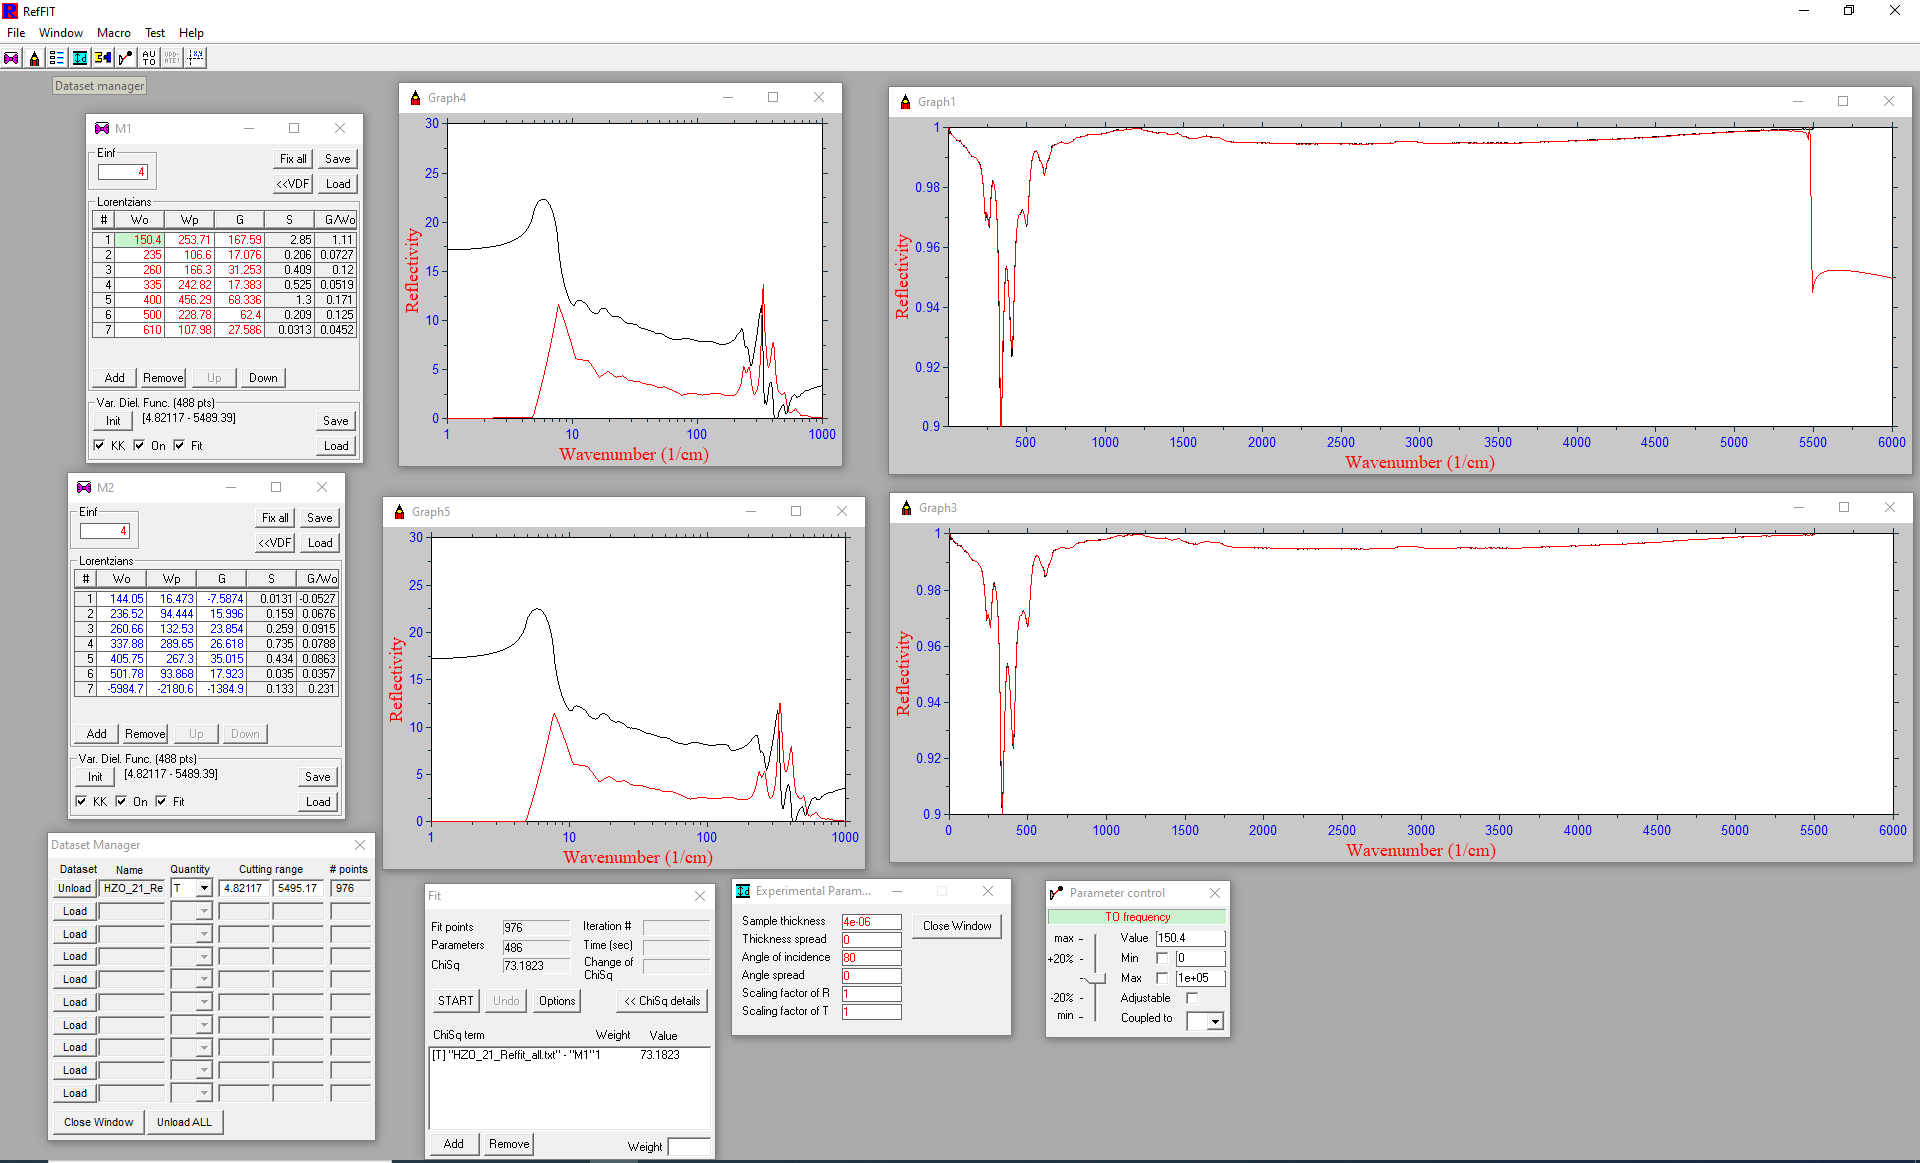

# 11nm RT

### THz

In [6]:
HZO11_THz_RT = txt_to_dic('THz/11nm_RT/HZO_11nm_four_12p5mm_300K_THz.txt')
Si_THz_RT = txt_to_dic('THz/11nm_RT/Si_four_12p5mm_THz_300K.txt')

In [7]:
HZO11_THz_RT['THz/11nm_RT/HZO_11nm_four_12p5mm_300K_THz.txt'].Frequency

0       4.94170
1       5.06223
2       5.18276
3       5.30329
4       5.42382
         ...   
783    99.31617
784    99.43670
785    99.55722
786    99.67775
787    99.79828
Name: Frequency, Length: 788, dtype: float64

In [8]:
Si_THz_RT['THz/11nm_RT/Si_four_12p5mm_THz_300K.txt'].Frequency[41]


9.8834

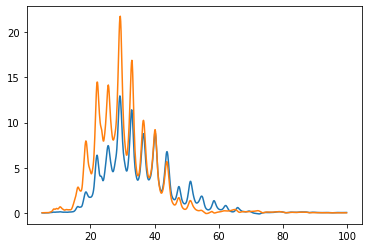

In [9]:
plt.plot(HZO11_THz_RT['THz/11nm_RT/HZO_11nm_four_12p5mm_300K_THz.txt'].Frequency, 
        HZO11_THz_RT['THz/11nm_RT/HZO_11nm_four_12p5mm_300K_THz.txt'].Absorbance)

plt.plot(Si_THz_RT['THz/11nm_RT/Si_four_12p5mm_THz_300K.txt'].Frequency, 
        Si_THz_RT['THz/11nm_RT/Si_four_12p5mm_THz_300K.txt'].Absorbance)

In [10]:
ref = Si_THz_RT['THz/11nm_RT/Si_four_12p5mm_THz_300K.txt'].Absorbance

In [11]:
AbsHZO11_THz_RT = (HZO11_THz_RT['THz/11nm_RT/HZO_11nm_four_12p5mm_300K_THz.txt'].Absorbance)/ref
AbsHZO11_THz_RT

0      -0.461310
1      -0.987138
2      -1.306802
3      -1.305430
4      -1.111207
         ...    
783     3.328405
784     3.553653
785     4.407252
786     6.579365
787    12.528169
Name: Absorbance, Length: 788, dtype: float64

In [12]:
array_HZO11_THz_RT = np.concatenate(
    ((np.array(HZO11_THz_RT['THz/11nm_RT/HZO_11nm_four_12p5mm_300K_THz.txt'].Frequency)).reshape(788, 1), (np.array(AbsHZO11_THz_RT)).reshape(788, 1)),
    axis=1)

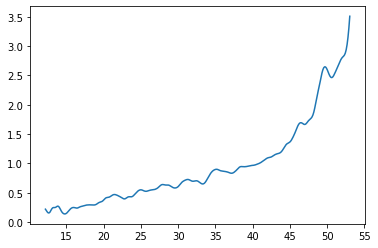

In [13]:
start = 60

end = 400

plt.plot(array_HZO11_THz_RT[start:end, 0], array_HZO11_THz_RT[start:end, 1])

### MIR

In [14]:
HZO11_MIR_RT = txt_to_dic('MIR/HZO_11nm_MIR_MCT.txt')
len(HZO11_MIR_RT)

1

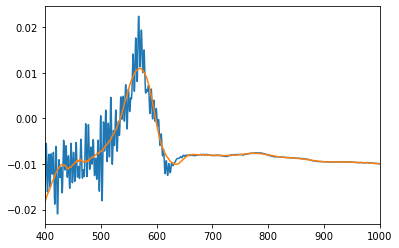

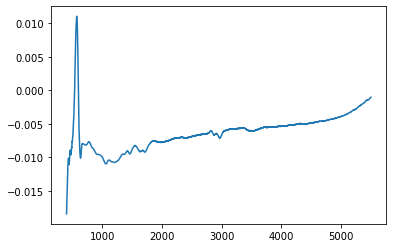

In [20]:
start_MIR = 0
end_MIR = len(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Absorbance)

MIR_11_sm = savitzky_golay((np.array(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Absorbance))[start_MIR:end_MIR], 171, 3)

plt.plot(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency, HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Absorbance)
plt.plot(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency[start_MIR:end_MIR], MIR_11_sm)

plt.xlim(400,1000)
# plt.ylim(-0.01,0)
plt.show()

plt.plot(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency[start_MIR:end_MIR], MIR_11_sm)

## FIR

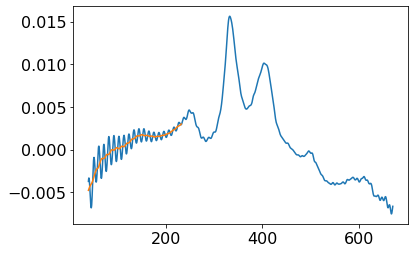

In [31]:
start_FIR = 0
end_FIR = 400

FIR_11_sm = savitzky_golay((np.array(d_HZO['HZO_11_RT.txt'].Absorbance))[start_FIR:end_FIR], 101, 3)

plt.plot(d_HZO['HZO_11_RT.txt'].Frequency, d_HZO['HZO_11_RT.txt'].Absorbance)
plt.plot(d_HZO['HZO_11_RT.txt'].Frequency[start_FIR:end_FIR], FIR_11_sm)

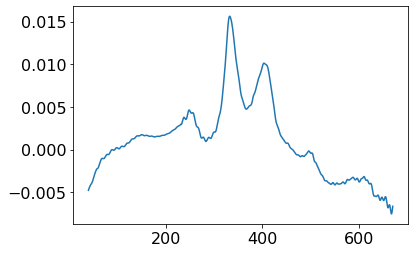

In [32]:
FIR_11_sm_final = np.concatenate((FIR_11_sm, np.array(d_HZO['HZO_11_RT.txt'].Absorbance)[end_FIR:]), axis=0)
plt.plot(d_HZO['HZO_11_RT.txt'].Frequency, FIR_11_sm_final)

In [33]:
find_peaks(FIR_11_sm_final, width=4)

(array([  60,   81,  102,  122,  144,  211,  229,  250,  271,  295,  410,
         433,  448,  493,  517,  607,  754,  855,  918,  946, 1050, 1068,
        1094, 1113, 1136, 1154, 1184, 1212, 1244, 1261, 1276, 1293],
       dtype=int64),
 {'prominences': array([3.88864226e-05, 2.14057716e-05, 7.12937993e-05, 1.37615082e-04,
         5.98457904e-05, 1.75236164e-05, 2.68168594e-04, 5.03001174e-05,
         3.93748307e-05, 2.40401516e-05, 2.40000000e-04, 3.68000000e-03,
         6.00000000e-05, 1.10000000e-04, 1.20000000e-04, 2.03968552e-02,
         5.38000000e-03, 2.00000000e-05, 9.00000000e-05, 6.70000000e-04,
         2.10000000e-04, 1.40000000e-04, 2.10000000e-04, 7.00000000e-05,
         5.50000000e-04, 1.90000000e-04, 9.80000000e-04, 6.00000000e-05,
         1.60000000e-04, 3.70000000e-04, 4.60000000e-04, 3.50000000e-04]),
  'left_bases': array([   0,    0,    0,    0,    0,    0,    0,  241,  263,  283,    0,
            0,  443,  487,  505,    0,  679,  851,  912,  912, 1042, 106

In [34]:
for i in find_peaks(FIR_11_sm_final, width=4)[0]:
    print(d_HZO['HZO_11_RT.txt'].Frequency[i])

68.460663
78.585121
88.709587
98.351929
108.95852
141.26038
149.93849
160.06294
170.18742
181.75822
237.20172
248.29042
255.52219
277.21747
288.78827
332.17883
403.05008
451.74393
482.11731
495.61661
545.75684
554.43494
566.96997
576.13019
587.21887
595.89703
610.36053
623.8598
639.2876
647.48358
654.71533
662.91132


HfO2 sp 29

<font color='red'>**114.2719    3.4258  (A1 )   A (   128.52)**</font> 88, 108
<br>
123.0310    3.6884  (B2 )   A (     5.36) 
143.2206    4.2936  (B1 )   A (    36.84) 141
<br>

<font color='red'>**152.1157    4.5603  (A1 )   A (   304.10)**</font>  150

<br>

<font color='black'>**227.5136    6.8207  (B1 )   A (  1930.65)**</font> 229

<br>

240.7106    7.2163  (B2 )   A (   183.61)   248

<br>
*249.4709    7.4789  (B1 )   A (    70.63)*  248

<br>

<font color='red'>**261.8462    7.8500  (A1 )   A (    66.76)**</font>
<br>

*267.0831    8.0070  (B2 )   A (  1422.50)*   255 
*318.3994    9.5454  (A1 )   A (   476.33)*   
322.2323    9.6603  (B2 )   A (   140.70)   
329.4216    9.8758  (B1 )   A (    32.57)   
<br>
<font color='red'>**338.7277   10.1548  (A1 )   A (  2364.66)**</font>
<br>
*379.8073   11.3863  (B2 )   A (  2460.35)*   
388.7418   11.6542  (A1 )   A (    11.07)   
*389.1224   11.6656  (B1 )   A (  2330.76)*   
<br>
<font color='red'>**465.8721   13.9665  (A1 )   A (   714.08)**</font>   
<br>
495.3346   14.8498  (B2 )   A (    92.62)   
533.3321   15.9889  (B1 )   A (   309.55)   
559.2718   16.7665  (B1 )   A (    16.67)   
<br>
<font color='red'>**594.7987   17.8316  (A1 )   A (    86.56)**</font>     
644.8698   19.3327  (B2 )   A (    98.69)   
711.5912   21.3330  (B2 )   A (    22.28)   
755.3618   22.6452  (B1 )   A (   304.43)   

## Plotting

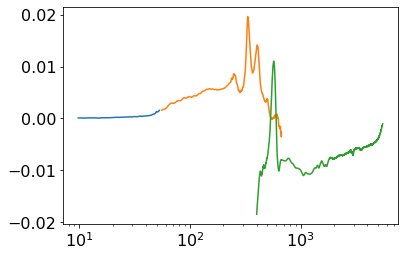

In [35]:
#THz
start_THz = 40
end_THz = 398
Abs_THz_11 = ((array_HZO11_THz_RT[start_THz:end_THz,1])*0.0005)
plt.plot(array_HZO11_THz_RT[start_THz:end_THz,0], Abs_THz_11)

#FIR
start_FIR = 33
end_FIR = -1
Abs_FIR_11 = FIR_11_sm_final[start_FIR:end_FIR]+0.004
plt.plot(d_HZO['HZO_11_RT.txt'].Frequency[start_FIR:end_FIR], Abs_FIR_11)

#MIR
plt.plot(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency, MIR_11_sm)

# plt.xlim(10,800)
# plt.ylim(-0.001,0.0025)
plt.xscale(value='log')

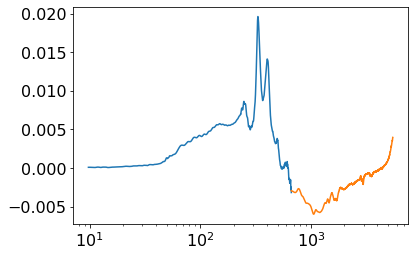

In [36]:
#Merging THz + FIR first

#THz + FIR

Abs_11_THz_FIR = np.concatenate((Abs_THz_11, Abs_FIR_11), axis=0)
wvn_11_THz_FIR = np.concatenate((array_HZO11_THz_RT[start_THz:end_THz,0], 
                                 d_HZO['HZO_11_RT.txt'].Frequency[start_FIR:end_FIR]), 
                                 axis=0)

start_THz_FIR = 0
end_THz_FIR = 1625

wvn_final_THz_FIR = wvn_11_THz_FIR[start_THz_FIR:end_THz_FIR]
Abs_final_THz_FIR = (Abs_11_THz_FIR[start_THz_FIR:end_THz_FIR])
plt.plot(wvn_final_THz_FIR, Abs_final_THz_FIR)

#MIR
start_MIR = 551
end_MIR = len(MIR_11_sm)

Abs_11_MIR = ((MIR_11_sm[start_MIR:end_MIR])+0.005)
wvn_11_MIR = HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency[start_MIR:end_MIR]
plt.plot(wvn_11_MIR, Abs_11_MIR)

# plt.xlim(600,700)
# plt.ylim(0,0.005)
plt.xscale(value='log')

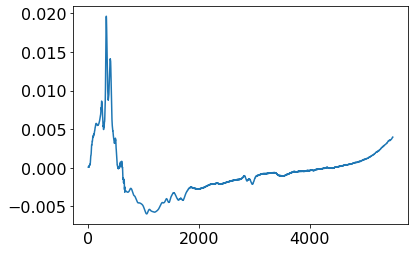

In [37]:
Abs_HZO_11_all = np.concatenate((Abs_final_THz_FIR, Abs_11_MIR), axis=0)
wvn_HZO_11_all = np.concatenate((wvn_final_THz_FIR, wvn_11_MIR), axis=0)

plt.plot(wvn_HZO_11_all, Abs_HZO_11_all)

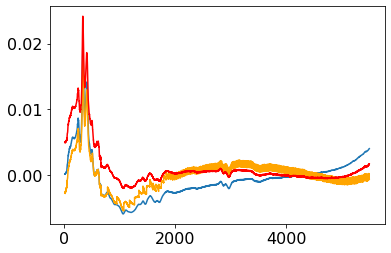

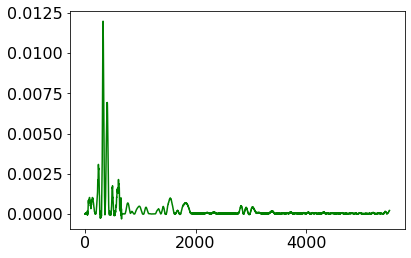

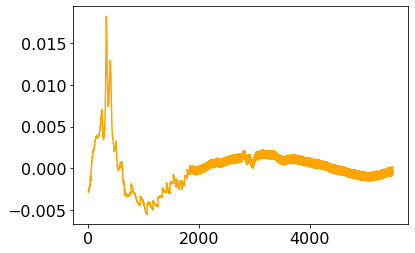

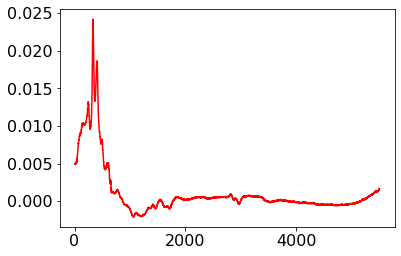

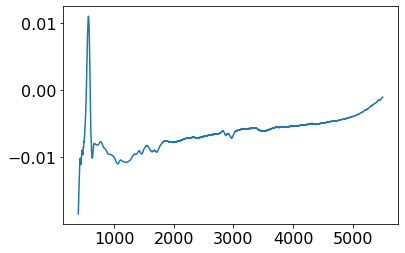

In [38]:
start = 0

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(Abs_HZO_11_all[start:])

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(wvn_HZO_11_all, Abs_HZO_11_all[start:])
plt.plot(wvn_HZO_11_all[start:], Modpoly_output, c='orange')
plt.plot(wvn_HZO_11_all[start:], Imodpoly_output, c='red')
plt.show()
plt.plot(wvn_HZO_11_all[start:], Zhangfit_output, c='green')

plt.show()
plt.plot(wvn_HZO_11_all[start:], Modpoly_output, c='orange')

plt.show()
plt.plot(wvn_HZO_11_all[start:], Imodpoly_output, c='red')

plt.show()
plt.plot(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency, MIR_11_sm)

# # plt.xlim(655,660)
# plt.ylim(0,0.005)
# plt.xscale(value='log')

In [39]:
T = 10**(-Abs_HZO_11_all)

In [40]:
start = 0
step = 12

HZO_11_all_test = np.concatenate((wvn_HZO_11_all[start::step].reshape(len(wvn_HZO_11_all[start::step]),1),
                                   T[start::step].reshape(len(T[start::step]), 1)), axis=1)

print(HZO_11_all_test.shape)

(972, 2)


In [41]:
# send to francesco!
start = 0
step = 1

HZO_11_all_test2 = np.concatenate((wvn_HZO_11_all[start::step].reshape(len(wvn_HZO_11_all[start::step]),1),
                                   T[start::step].reshape(len(T[start::step]), 1)), axis=1)

print(HZO_11_all_test2.shape)

(11653, 2)


In [42]:
# SEND TO FRANCESCO SMIS
with open("long_data.txt", 'w') as txt:
    np.savetxt(txt, HZO_11_all_test2, delimiter=' ', newline='\n')

In [ ]:
#Low frequency
fin = 109
plt.plot(HZO_11_all_test[:fin,0], (HZO_11_all_test[:fin,1]))


#High frequency
start = fin
end = 976

plt.plot(HZO_11_all_test[start:end,0], ((HZO_11_all_test[start:end,1])*0.3)+(1-0.30439))

# plt.ylim(0.975,1)
# plt.xlim(350, 6050)
# plt.xscale('log')


wvn_HZO_11_all_final = np.concatenate((HZO_11_all_test[:fin,0], HZO_11_all_test[start:end,0]), axis=0)
Abs_HZO_11_all_1 = np.concatenate( ( (HZO_11_all_test[:fin,1]), (HZO_11_all_test[start:end,1])*0.3+(1-0.30439) ), 
                        axis=0)

Abs_HZO_11_all_final = Abs_HZO_11_all_1-0.0002

wvn_HZO_11_all_final.shape
Abs_HZO_11_all_final.shape

In [ ]:
plt.plot(wvn_HZO_11_all_final,  Abs_HZO_11_all_final)

HZO_11_all_final = np.concatenate((wvn_HZO_11_all_final.reshape(972,1), Abs_HZO_11_all_final.reshape(972,1)), axis=1)
plt.xscale('log')
plt.ylim(0.975,1)

In [ ]:
with open("HZO_11_Reffit_all.txt", 'w') as txt:
    np.savetxt(txt, HZO_11_all_final, delimiter=' ', newline='\n')

# 21 nm 736 K
- MIR semaine du 9 Oct

### *THz*

In [ ]:
HZO21_THz_736K = txt_to_dic('THz/21nm_HighT/HZO21_736K_THz.txt')
Si_THz_736K = txt_to_dic('THz/21nm_HighT/Si_four_736K_THz.txt')

In [ ]:
plt.plot(HZO21_THz_736K['THz/21nm_HighT/HZO21_736K_THz.txt'].Frequency, 
        HZO21_THz_736K['THz/21nm_HighT/HZO21_736K_THz.txt'].Absorbance)

plt.plot(Si_THz_736K['THz/21nm_HighT/Si_four_736K_THz.txt'].Frequency, 
        Si_THz_736K['THz/21nm_HighT/Si_four_736K_THz.txt'].Absorbance)

In [ ]:
AbsHZO21_THz_736K = (HZO21_THz_736K['THz/21nm_HighT/HZO21_736K_THz.txt'].Absorbance)/Si_THz_736K['THz/21nm_HighT/Si_four_736K_THz.txt'].Absorbance
AbsHZO21_THz_736K

In [ ]:
array_AbsHZO21_THz_736K = np.concatenate(
    ((np.array(HZO21_THz_736K['THz/21nm_HighT/HZO21_736K_THz.txt'].Frequency)).reshape(829, 1), (np.array(AbsHZO21_THz_736K)).reshape(829, 1)),
    axis=1)

In [ ]:
start = 60

end = 400

plt.plot(array_AbsHZO21_THz_736K[start:end, 0], array_AbsHZO21_THz_736K[start:end, 1])

### *FIR*

In [ ]:
plt.plot(dic_AbsHZO21['736'].Frequency, dic_AbsHZO21['736'].Absorbance)

In [ ]:
plt.plot(dic_AbsHZO21_BaselineRemoval_final['736'][:, 0], dic_AbsHZO21_BaselineRemoval_final['736'][:, 1])

In [ ]:
sm = savitzky_golay(dic_AbsHZO21_BaselineRemoval_final['736'][start_FIR:end_FIR, 1], 31, 3)

plt.plot(dic_AbsHZO21_BaselineRemoval_final['736'][:, 0], dic_AbsHZO21_BaselineRemoval_final['736'][start_FIR:end_FIR, 1])
plt.plot(dic_AbsHZO21_BaselineRemoval_final['736'][start_FIR:end_FIR, 0], sm)

FIR_HZO21_736K = sm

### *MIR*
- semaine du 9 Oct

## Plotting THz+MIR

In [ ]:
start_FIR= 2

plt.plot(dic_AbsHZO21_BaselineRemoval_final['736'][start_FIR:, 0], dic_AbsHZO21_BaselineRemoval_final['736'][start_FIR:, 1])

start = 60
end = 618

plt.plot(array_AbsHZO21_THz_736K[start:end, 0], array_AbsHZO21_THz_736K[start:end, 1]*0.01-0.009)
plt.xscale('log')
plt.xlim(50,90)

plt.show()

Abs_21_THz_FIR_736K = np.concatenate((array_AbsHZO21_THz_736K[start:end, 1]*0.01-0.009, 
                                      dic_AbsHZO21_BaselineRemoval_final['736'][start_FIR:, 1]), axis=0)
wvn_21_THz_FIR_736K = np.concatenate((array_AbsHZO21_THz_736K[start:end, 0], 
                                 dic_AbsHZO21_BaselineRemoval_final['736'][start_FIR:, 0]), 
                                 axis=0)

plt.plot(wvn_21_THz_FIR_736K, Abs_21_THz_FIR_736K)

In [ ]:

sm = savitzky_golay(Abs_21_THz_FIR_736K,31,3)

end1 = 706
sm2 = savitzky_golay(Abs_21_THz_FIR_736K[:end1],251,3)

plt.plot(wvn_21_THz_FIR_736K, Abs_21_THz_FIR_736K)
plt.plot(wvn_21_THz_FIR_736K, sm)
plt.plot(wvn_21_THz_FIR_736K[:end1], sm2)
plt.xscale('log')

plt.show()

sm_trial2_Abs_21_THz_FIR_736K = np.concatenate((sm2, sm[end1:]), axis=0)
plt.plot(wvn_21_THz_FIR_736K, sm_trial2_Abs_21_THz_FIR_736K)
plt.xscale('log')

plt.show()
sm3 = savitzky_golay(sm_trial2_Abs_21_THz_FIR_736K[:end1],351,3)
plt.plot(wvn_21_THz_FIR_736K, sm_trial2_Abs_21_THz_FIR_736K)
plt.plot(wvn_21_THz_FIR_736K[:end1], sm3)

sm_trial3_Abs_21_THz_FIR_736K = np.concatenate((sm3, sm_trial2_Abs_21_THz_FIR_736K[end1:]), axis=0)
# plt.xscale('log')

shift = 0.0018
plt.plot(wvn_21_THz_FIR_736K, sm_trial3_Abs_21_THz_FIR_736K+shift)
final2_Abs_21_THz_FIR_736K = sm_trial3_Abs_21_THz_FIR_736K+shift

In [ ]:
# plt.plot(dic_AbsHZO21['736'].Frequency, dic_AbsHZO21['736'].Absorbance*0.02+0.006)

# start = 60
# end = 700

# plt.plot(array_AbsHZO21_THz_736K[start:end, 0], array_AbsHZO21_THz_736K[start:end, 1]*0.005-0.004)
# plt.ylim(-0.005,0.01)
# plt.xscale('log')

In [ ]:
end1 = 280
sm = savitzky_golay(Abs_21_THz_FIR_736K[:end1],251,3)

beg2 = 280
end2 = 700
sm2 = savitzky_golay(Abs_21_THz_FIR_736K[beg2:end2],251,3)

plt.plot(wvn_21_THz_FIR_736K, Abs_21_THz_FIR_736K)
plt.plot(wvn_21_THz_FIR_736K[:end1], sm, c='orange')

plt.plot(wvn_21_THz_FIR_736K[beg2:end2], sm2, c='green')

plt.xscale('log')

plt.show()

sm_Abs_21_THz_FIR_736K = np.concatenate((sm, sm2, Abs_21_THz_FIR_736K[end2:]), axis=0)
plt.plot(wvn_21_THz_FIR_736K, sm_Abs_21_THz_FIR_736K)
plt.xscale('log')

In [ ]:
end1 = 700
sm = savitzky_golay(Abs_21_THz_FIR_736K[:end1],251,3)

# beg2 = 280
# end2 = 700
# sm2 = savitzky_golay(Abs_21_THz_FIR_736K[beg2:end2],251,3)

plt.plot(wvn_21_THz_FIR_736K, Abs_21_THz_FIR_736K)
plt.plot(wvn_21_THz_FIR_736K[:end1], sm, c='orange')

# plt.plot(wvn_21_THz_FIR_736K[beg2:end2], sm2, c='green')

plt.xscale('log')

plt.show()

sm_Abs_21_THz_FIR_736K = np.concatenate((sm, Abs_21_THz_FIR_736K[end1:]), axis=0)
plt.plot(wvn_21_THz_FIR_736K, sm_Abs_21_THz_FIR_736K)
plt.xscale('log')
plt.show()

shift = 0.003
plt.plot(wvn_21_THz_FIR_736K, sm_Abs_21_THz_FIR_736K+shift)
final_Abs_21_THz_FIR_736K = sm_Abs_21_THz_FIR_736K+shift

In [ ]:
final_Abs_21_THz_FIR_736K.shape

In [ ]:
T = 10**(-final_Abs_21_THz_FIR_736K)

start = 0
step = 1

final_HZO_21_THz_FIR_736K_test = np.concatenate((wvn_21_THz_FIR_736K[start::step].reshape(len(wvn_21_THz_FIR_736K[start::step]),1),
                                   T[start::step].reshape(len(T[start::step]), 1)), axis=1)

print(final_Abs_21_THz_FIR_736K_test.shape)


In [ ]:
T = 10**(-final2_Abs_21_THz_FIR_736K)

start = 0
step = 1

final2_Abs_21_THz_FIR_736K_test = np.concatenate((wvn_21_THz_FIR_736K[start::step].reshape(len(wvn_21_THz_FIR_736K[start::step]),1),
                                   T[start::step].reshape(len(T[start::step]), 1)), axis=1)

print(final2_Abs_21_THz_FIR_736K_test.shape)

In [ ]:
with open("HZO_21_Reffit_THz_FIR_736K.txt", 'w') as txt:
    np.savetxt(txt, final2_Abs_21_THz_FIR_736K_test, delimiter=' ', newline='\n')

# 11 nm 736 K 
- THz at MIR à faire semaine du 9 Oct

### *THz*
- semaine du 9 Oct

### *FIR*

In [ ]:
FIR_11nm_736K = savitzky_golay(dic_AbsHZO11_BaselineRemoval_final['High_T/11nm\\738.txt'][:,1], 101, 3)
FIR_11nm_736K_wvn = dic_AbsHZO11_BaselineRemoval_final['High_T/11nm\\738.txt'][:,0]
plt.plot(FIR_11nm_736K_wvn, FIR_11nm_736K)

### *MIR*
- semaine du 9 Oct

# 17 nm RT

### *THz* 


In [ ]:
HZO_17_RT = txt_to_dic('THz/17_52_10_nm/HZO_17_THz_RT.dpt')
HZO_17_RT

In [ ]:
start = 60

end = 400

plt.plot(HZO_17_RT['THz/17_52_10_nm/HZO_17_THz_RT.dpt'].Frequency[start:end], 
         HZO_17_RT['THz/17_52_10_nm/HZO_17_THz_RT.dpt'].Absorbance[start:end])

### *FIR*

In [ ]:
HZO17_FIR_RT = txt_to_dic('FIR/HZO_17_RT.txt')

plt.plot(HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Frequency, HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Absorbance)


In [ ]:
start_FIR = 0
end_FIR = 400

sm = savitzky_golay((np.array(HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Absorbance))[start_FIR:end_FIR], 101, 3)
FIR_17_sm = np.concatenate((sm, HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Absorbance[end_FIR:]))

plt.plot(HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Frequency, HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Absorbance)
plt.plot(HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Frequency, FIR_17_sm)

### *MIR*

In [ ]:
HZO17_MIR_RT = txt_to_dic('MIR/HZO_17nm_MIR_MCT.dpt')
HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt']

In [ ]:
plt.plot(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Frequency, HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Absorbance)

In [ ]:
start_MIR = 0
end_MIR = len(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Absorbance)

MIR_17_sm = savitzky_golay((np.array(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Absorbance))[start_MIR:end_MIR], 331, 3)

plt.plot(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Frequency, HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Absorbance)
plt.plot(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Frequency[start_MIR:end_MIR], MIR_17_sm)

# plt.xlim(1000,2000)
# plt.ylim(-0.01,0)
plt.show()

plt.plot(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Frequency[start_MIR:end_MIR], MIR_17_sm)

## Plotting THz+FIR+MIR

In [ ]:
plt.figure(figsize=(10,6))
#THz
start_THz = 58
end_THz = 403
Abs_THz_17 = ((HZO_17_RT['THz/17_52_10_nm/HZO_17_THz_RT.dpt'].Absorbance[start_THz:end_THz])*0.005+0.001)
plt.plot(HZO_17_RT['THz/17_52_10_nm/HZO_17_THz_RT.dpt'].Frequency[start_THz:end_THz], Abs_THz_17)

#FIR
start_FIR = 20
end_FIR = -2
Abs_FIR_17 = FIR_17_sm[start_FIR:end_FIR]+0.0023
plt.plot(HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Frequency[start_FIR:end_FIR], Abs_FIR_17)

#MIR
start_MIR = 555
end_MIR = len(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Absorbance)

MIR_17_final = MIR_17_sm-0.093
plt.plot(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Frequency[start_MIR:end_MIR], MIR_17_final[start_MIR:end_MIR])

# plt.xlim(10,800)
# plt.ylim(-0.001,0.0025)
plt.xscale(value='log')


In [ ]:
plt.figure(figsize=(10,6))

start_THz = 58
end_THz = 403

start_FIR = 20
end_FIR = -2

THz_FIR_17 = np.concatenate((Abs_THz_17, Abs_FIR_17), axis=0)
wvn_THz_FIR_17 = np.concatenate((HZO_17_RT['THz/17_52_10_nm/HZO_17_THz_RT.dpt'].Frequency[start_THz:end_THz], 
                                HZO17_FIR_RT['FIR/HZO_17_RT.txt'].Frequency[start_FIR:end_FIR]))
# THz + FIR
plt.plot(wvn_THz_FIR_17, THz_FIR_17*0.9)


#MIR
start_MIR = 555
end_MIR = len(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Absorbance)


MIR_17_final = MIR_17_sm*0.9-0.0926
plt.plot(HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Frequency[start_MIR:end_MIR], MIR_17_final[start_MIR:end_MIR])

plt.xscale(value='log')
# plt.xlim(500,800)

In [ ]:
abs_17 = np.concatenate((THz_FIR_17, MIR_17_final[start_MIR:end_MIR]), axis=0) 
wvn_17 = np.concatenate((wvn_THz_FIR_17, HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt'].Frequency[start_MIR:end_MIR]), axis=0)

plt.plot(wvn_17, abs_17)

In [ ]:
start = 0

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(abs_17[start:])

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(wvn_17, abs_17[start:])
plt.plot(wvn_17[start:], Modpoly_output, c='orange')
plt.plot(wvn_17[start:], Imodpoly_output, c='red')
plt.show()
plt.plot(wvn_17[start:], Zhangfit_output, c='green')

plt.show()
plt.plot(wvn_17[start:], Modpoly_output, c='orange')

plt.show()
plt.plot(wvn_17[start:], Imodpoly_output, c='red')

plt.show()
# plt.plot(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency, MIR_11_sm)

# # plt.xlim(655,660)
# plt.ylim(0,0.005)
# plt.xscale(value='log')

In [ ]:
T = 10**(-Modpoly_output-0.0001)

In [ ]:
start = 0
step = 12

HZO_17_all_test = np.concatenate((wvn_17[start::step].reshape(len(wvn_17[start::step]),1),
                                   T[start::step].reshape(len(T[start::step]), 1)), axis=1)

print(HZO_17_all_test.shape)

In [ ]:
plt.plot(HZO_17_all_test[:,0], HZO_17_all_test[:,1])
plt.ylim(0.98,1)

In [ ]:
plt.plot(wvn_17, Modpoly_output, c='orange')

In [ ]:
with open("HZO_17_Reffit_all.txt", 'w') as txt:
    np.savetxt(txt, HZO_17_all_test, delimiter=' ', newline='\n')

# 17 nm 13 K
- MIR missing, semaine du 9 Oct

### *THz*

In [ ]:
HZO_17_THz_13K = txt_to_dic('THz/17_52_10_nm/HZO_17_THz_13K.dpt')
HZO_17_THz_13K['THz/17_52_10_nm/HZO_17_THz_13K.dpt']

In [ ]:
start = 60

end = 400

plt.plot(HZO_17_THz_13K['THz/17_52_10_nm/HZO_17_THz_13K.dpt'].Frequency[start:end], 
         HZO_17_THz_13K['THz/17_52_10_nm/HZO_17_THz_13K.dpt'].Absorbance[start:end])

### *FIR*

In [ ]:
HZO17_FIR_13K = txt_to_dic('FIR/HZO_17nm_13K.dpt')

plt.plot(HZO17_FIR_13K['FIR/HZO_17nm_13K.dpt'].Frequency, HZO17_FIR_13K['FIR/HZO_17nm_13K.dpt'].Absorbance)


In [ ]:
start_FIR = 0
end_FIR = len(HZO17_FIR_13K['FIR/HZO_17nm_13K.dpt'].Absorbance)

FIR_17_13K_sm = savitzky_golay((np.array(HZO17_FIR_13K['FIR/HZO_17nm_13K.dpt'].Absorbance))[start_FIR:end_FIR], 101, 3)

plt.plot(HZO17_FIR_13K['FIR/HZO_17nm_13K.dpt'].Frequency, HZO17_FIR_13K['FIR/HZO_17nm_13K.dpt'].Absorbance)
plt.plot(HZO17_FIR_13K['FIR/HZO_17nm_13K.dpt'].Frequency[start_FIR:end_FIR], FIR_17_13K_sm)

### *MIR*
semaine du 09 Oct

In [ ]:
HZO17_MIR_RT = txt_to_dic('MIR/HZO_17nm_MIR_MCT.dpt')
HZO17_MIR_RT['MIR/HZO_17nm_MIR_MCT.dpt']

# 10 nm RT


### *THz*

In [189]:
HZO_10_THz = txt_to_dic('THz/17_52_10_nm/HZO_10_THz.dpt')
HZO_10_THz['THz/17_52_10_nm/HZO_10_THz.dpt']

,Frequency,Absorbance
0,0.00000,0.40031
1,0.12053,0.31721
2,0.24106,0.12783
3,0.36159,-0.10697
4,0.48212,-0.37112
...,...,...
1654,199.35551,-0.93473
1655,199.47604,-0.94617
1656,199.59657,-0.89232
1657,199.71710,-0.88414


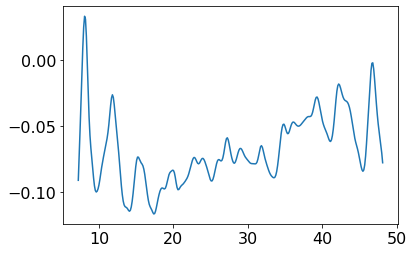

In [191]:
start = 60

end = 400

plt.plot(HZO_10_THz['THz/17_52_10_nm/HZO_10_THz.dpt'].Frequency[start:end], 
         HZO_10_THz['THz/17_52_10_nm/HZO_10_THz.dpt'].Absorbance[start:end])

### *FIR*

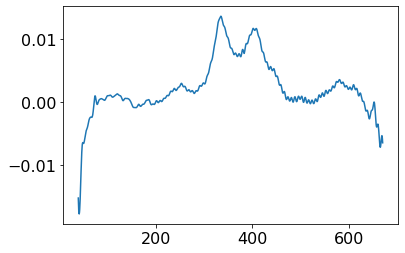

In [192]:
HZO10_FIR_RT = txt_to_dic('FIR/HZO_10_RT.txt')

plt.plot(HZO10_FIR_RT['FIR/HZO_10_RT.txt'].Frequency, HZO10_FIR_RT['FIR/HZO_10_RT.txt'].Absorbance)

(1310,)

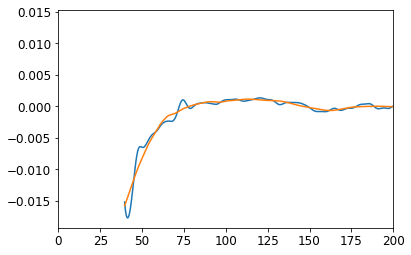

In [1203]:
FIR_10_sm = smooth_FIR(HZO10_FIR_RT['FIR/HZO_10_RT.txt'])
plt.xlim(0,200)
FIR_10_sm.shape
HZO10_FIR_RT['FIR/HZO_10_RT.txt'].Frequency.shape

### *MIR*

In [194]:
HZO10_MIR_RT = txt_to_dic('MIR/HZO_10nm_MIR_MCT.txt')
len(HZO10_MIR_RT)

1

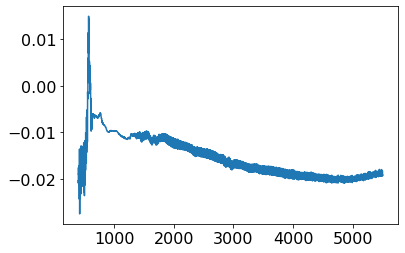

In [195]:
plt.plot(HZO10_MIR_RT['MIR/HZO_10nm_MIR_MCT.txt'].Frequency, HZO10_MIR_RT['MIR/HZO_10nm_MIR_MCT.txt'].Absorbance)

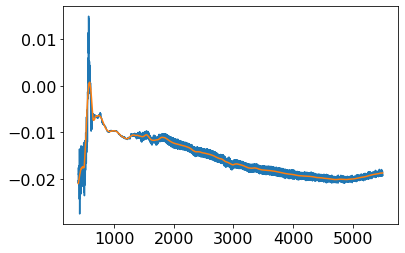

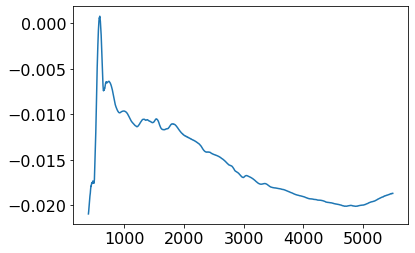

In [196]:
MIR_10_sm = smooth_MIR(HZO10_MIR_RT['MIR/HZO_10nm_MIR_MCT.txt'])

## Plotting all together

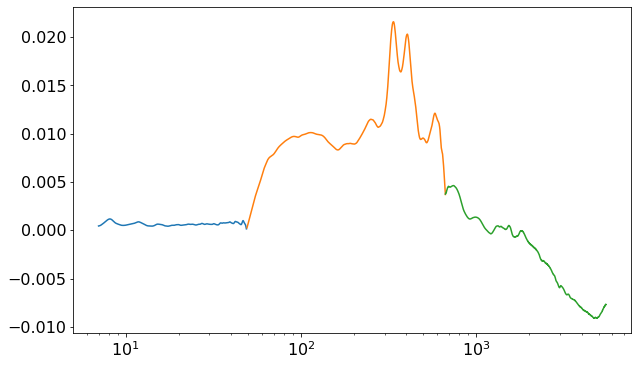

In [197]:
plt.figure(figsize=(10,6))
#THz
start_THz = 58
end_THz = 406

wvn_10_THz = HZO_10_THz['THz/17_52_10_nm/HZO_10_THz.dpt'].Frequency[start_THz:end_THz]
Abs_THz_10 = ((HZO_10_THz['THz/17_52_10_nm/HZO_10_THz.dpt'].Absorbance[start_THz:end_THz])*0.005+0.001)

plt.plot(wvn_10_THz, Abs_THz_10)

#FIR
start_FIR = 20
end_FIR = -6

wvn_FIR_10 = HZO10_FIR_RT['FIR/HZO_10_RT.txt'].Frequency[start_FIR:end_FIR]
Abs_FIR_10 = FIR_10_sm[start_FIR:end_FIR]+0.009
plt.plot(wvn_FIR_10, Abs_FIR_10)

#MIR
start_MIR = 555
end_MIR = len(HZO10_MIR_RT['MIR/HZO_10nm_MIR_MCT.txt'].Absorbance)

wvn_MIR_10 = HZO10_MIR_RT['MIR/HZO_10nm_MIR_MCT.txt'].Frequency[start_MIR:end_MIR]
MIR_10_final = MIR_10_sm[start_MIR:end_MIR]+0.011

plt.plot(wvn_MIR_10, MIR_10_final)

# plt.xlim(500,800)
# plt.ylim(-0.001,0.0025)
plt.xscale(value='log')

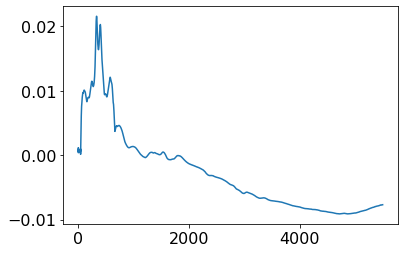

In [198]:
Abs_HZO_10_all = np.concatenate((Abs_THz_10, Abs_FIR_10, MIR_10_final), axis=0)
wvn_HZO_10_all = np.concatenate((wvn_10_THz, wvn_FIR_10, wvn_MIR_10), axis=0)

plt.plot(wvn_HZO_10_all, Abs_HZO_10_all)

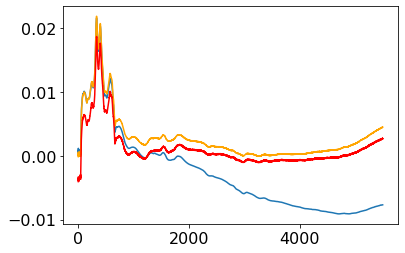

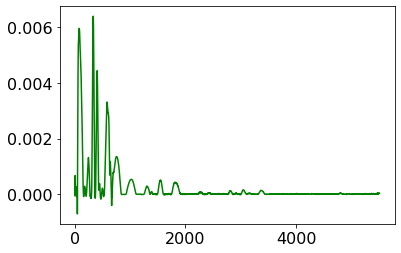

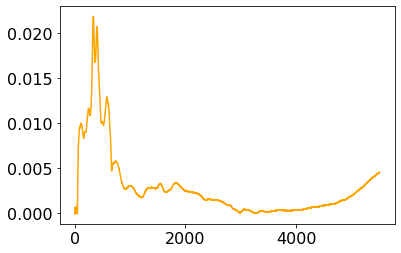

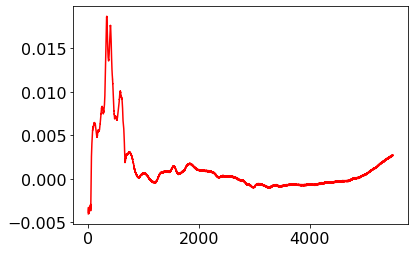

In [199]:
start = 0

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(Abs_HZO_10_all[start:])

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(wvn_HZO_10_all, Abs_HZO_10_all[start:])
plt.plot(wvn_HZO_10_all[start:], Modpoly_output, c='orange')
plt.plot(wvn_HZO_10_all[start:], Imodpoly_output, c='red')
plt.show()
plt.plot(wvn_HZO_10_all[start:], Zhangfit_output, c='green')

plt.show()
plt.plot(wvn_HZO_10_all[start:], Modpoly_output, c='orange')

plt.show()
plt.plot(wvn_HZO_10_all[start:], Imodpoly_output, c='red')

plt.show()
# plt.plot(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency, MIR_11_sm)

# # plt.xlim(655,660)
# plt.ylim(0,0.005)
# plt.xscale(value='log')

(972, 2)


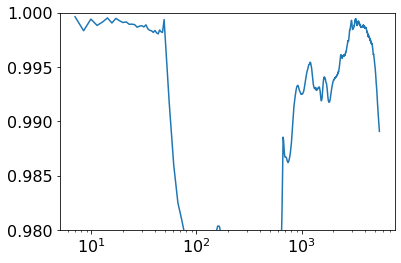

In [358]:
T = 10**(-Modpoly_output-0.0003)

start = 0
step = 12

HZO_10_all_test = np.concatenate((wvn_HZO_10_all[start::step].reshape(len(wvn_HZO_10_all[start::step]),1),
                                   T[start::step].reshape(len(T[start::step]), 1)), axis=1)

print(HZO_10_all_test.shape)

plt.plot(HZO_10_all_test[:,0], HZO_10_all_test[:,1])
plt.ylim(0.98,1)
plt.xscale(value='log')

#### Trying to better connect THz and FIR using PlynomialFeatures of Sklearn

In [245]:
## Trying to better connect THz and FIR

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

In [211]:
HZO_10_all_test[20]

array([35.91774  ,  0.9983704])

In [213]:
HZO_10_all_test[35]

array([83.888412  ,  0.97833914])

In [253]:
X = HZO_10_all_test[20:35]

In [265]:
start = 10
end = 45

X = HZO_10_all_test[start:end,0].reshape(len(HZO_10_all_test[start:end,0]),1)
y = HZO_10_all_test[start:end,1].reshape(len(HZO_10_all_test[start:end,1]),1)

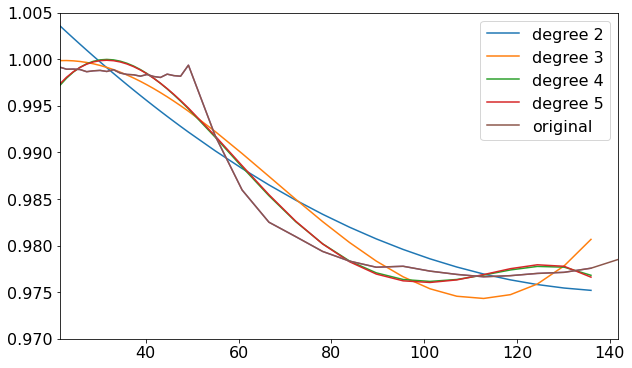

In [267]:
# polynomial features
fig, ax = plt.subplots(figsize=(10,6))

for degree in [2, 3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X, y)
    y_plot = model.predict(X)
    ax.plot(X, y_plot, label=f"degree {degree}")

ax.plot(X,y)
ax.plot(HZO_10_all_test[:,0],HZO_10_all_test[:,1], label='original')
ax.set_xlim(HZO_10_all_test[start,0], HZO_10_all_test[end,0])
ax.set_ylim(0.97,1.005)

ax.legend()

In [268]:
start = 10
end = 45

X = HZO_10_all_test[start:end,0].reshape(len(HZO_10_all_test[start:end,0]),1)
y = HZO_10_all_test[start:end,1].reshape(len(HZO_10_all_test[start:end,1]),1)

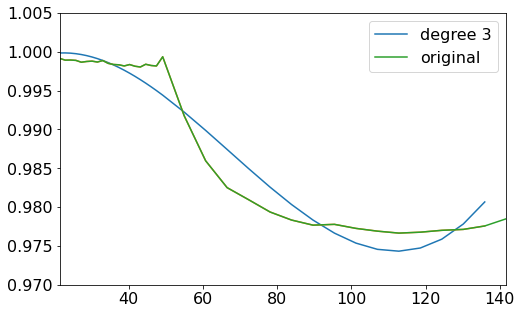

In [299]:
# I choose the 3 to be the best

# polynomial features degree 3
fig, ax = plt.subplots(figsize=(8,5))

model = make_pipeline(PolynomialFeatures(3), Ridge(alpha=1e-3))
model.fit(X, y)
y_plot = model.predict(X)
ax.plot(X, y_plot, label=f"degree {3}")

ax.plot(X,y)
ax.plot(HZO_10_all_test[:,0],HZO_10_all_test[:,1], label='original')
ax.set_xlim(HZO_10_all_test[start,0], HZO_10_all_test[end,0])
ax.set_ylim(0.97,1.005)

ax.legend()

In [277]:
y_plot
#beginning of concatenate is:
X[9]

array([34.47139])

In [298]:
#end of concatenate is:
X[26]

array([89.67382])

In [308]:
#end of concatenate is:
HZO_10_all_test[19]

array([34.47139   ,  0.99851523])

In [313]:
#beginning of concatenate is:
HZO_10_all_test[36]

array([89.67382   ,  0.97768133])

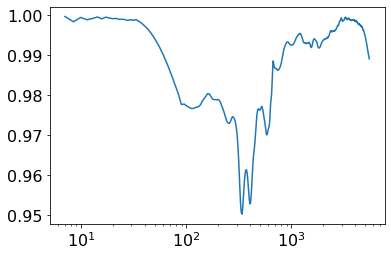

In [320]:
test_y = np.concatenate((HZO_10_all_test[:19,1].reshape(len(HZO_10_all_test[:19,1]),1), 
                         y_plot[9:26].reshape(len(y_plot[9:26]), 1), 
                         HZO_10_all_test[36:,1].reshape(len(HZO_10_all_test[36:,1]),1)
                        ), axis=0)

plt.plot(HZO_10_all_test[:,0], test_y)
plt.xscale(value='log')

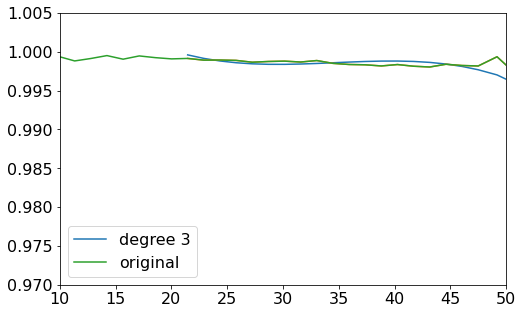

In [345]:
# lets try a shorter range for the fit

start = 10
end = 32

X = HZO_10_all_test[start:end,0].reshape(len(HZO_10_all_test[start:end,0]),1)
y = HZO_10_all_test[start:end,1].reshape(len(HZO_10_all_test[start:end,1]),1)

# I choose the 3 to be the best

# polynomial features degree 3
fig, ax = plt.subplots(figsize=(8,5))

model = make_pipeline(PolynomialFeatures(3), Ridge(alpha=1e-3))
model.fit(X, y)
y_plot = model.predict(X)
ax.plot(X, y_plot, label=f"degree {3}")

ax.plot(X,y)
ax.plot(HZO_10_all_test[:,0],HZO_10_all_test[:,1], label='original')
# ax.set_xlim(HZO_10_all_test[start,0], HZO_10_all_test[end,0])
ax.set_xlim(10, 50)
ax.set_ylim(0.97,1.005)

ax.legend()

In [346]:
#beginning of concatenate is:
X[16:]
#and the end is the final value

array([[44.59585 ],
       [46.0422  ],
       [47.48855 ],
       [49.175968],
       [54.961369],
       [60.74678 ]])

In [361]:
HZO_10_all_test[26:31]

array([[44.59585   ,  0.99839925],
       [46.0422    ,  0.9982405 ],
       [47.48855   ,  0.99817769],
       [49.175968  ,  0.99936432],
       [54.961369  ,  0.99176892]])

In [362]:
HZO_10_all_test[31]

array([60.74678   ,  0.98596942])

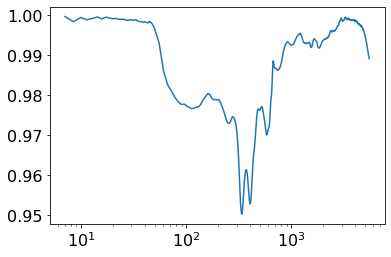

In [363]:
test_y = np.concatenate((HZO_10_all_test[:26,1].reshape(len(HZO_10_all_test[:26,1]),1), 
                         y_plot[16:-1].reshape(len(y_plot[16:-1]), 1), 
                         HZO_10_all_test[31:,1].reshape(len(HZO_10_all_test[31:,1]),1)
                        ), axis=0)

plt.plot(HZO_10_all_test[:,0], test_y)
plt.xscale(value='log')

#### Final concatenating X and y into one array and saving it for reffit

In [364]:
HZO_10_all_test = np.concatenate((HZO_10_all_test[:,0].reshape(len(HZO_10_all_test[:,0]),1),
                                   test_y.reshape(len(test_y), 1)), axis=1)

In [365]:
with open("HZO_10_Reffit_all.txt", 'w') as txt:
    np.savetxt(txt, HZO_10_all_test, delimiter=' ', newline='\n')

#### Linear Model - not good

In [221]:
## Trying to better connect THz and FIR

from sklearn.linear_model import LinearRegression

In [228]:
X = HZO_10_all_test[20:80,0].reshape(len(HZO_10_all_test[20:80,0]),1)
y = HZO_10_all_test[20:80,1].reshape(len(HZO_10_all_test[20:80,1]),1)

In [227]:
X.shape

(60, 1)

In [240]:
reg = LinearRegression()
reg.fit(X,y)
y_pred = reg.predict(X)
# y_pred
# # Create linear regression object
# regr = linear_model.LinearRegression()

# # Train the model using the training sets
# regr.fit(diabetes_X_train, diabetes_y_train)

# # Make predictions using the testing set
# diabetes_y_pred = regr.predict(diabetes_X_test)

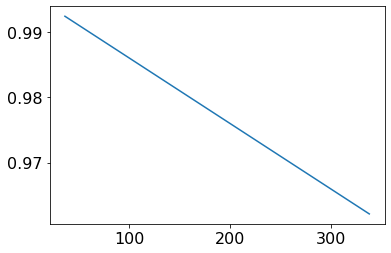

In [241]:
plt.plot(X,y_pred)

# 52 nm RT
- ready for reffit

### *THz*

In [378]:
HZO_52_THz = txt_to_dic('THz/17_52_10_nm/HZO_52_THz.dpt')
Abs_THz_52 = HZO_52_THz["THz/17_52_10_nm/HZO_52_THz.dpt"].Absorbance
wvn_THz_52 = HZO_52_THz["THz/17_52_10_nm/HZO_52_THz.dpt"].Frequency

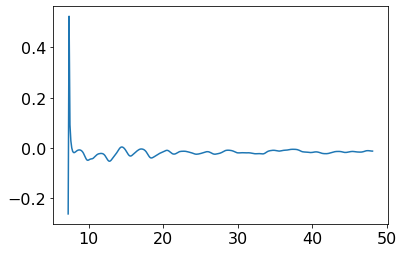

In [379]:
start = 60

end = 400

plt.plot(wvn_THz_52[start:end], Abs_THz_52[start:end])

### *FIR*

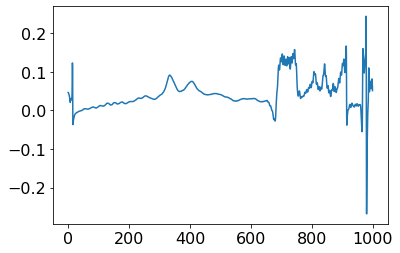

In [380]:
HZO52_FIR_RT = txt_to_dic('FIR/HZO_52_RT.txt')

plt.plot(HZO52_FIR_RT['FIR/HZO_52_RT.txt'].Frequency, HZO52_FIR_RT['FIR/HZO_52_RT.txt'].Absorbance)

### *MIR* 

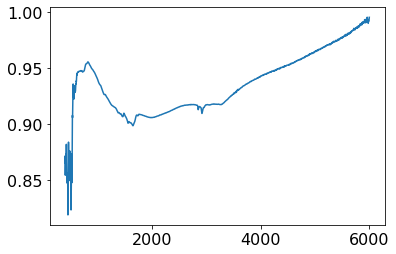

In [381]:
HZO52_MIR_RT = txt_to_dic('MIR/HZO_52nm_MIR_MCT.dpt')
plt.plot(HZO52_MIR_RT['MIR/HZO_52nm_MIR_MCT.dpt'].Frequency, HZO52_MIR_RT['MIR/HZO_52nm_MIR_MCT.dpt'].Absorbance)

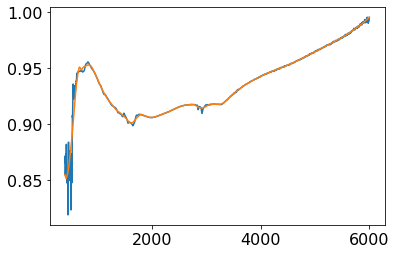

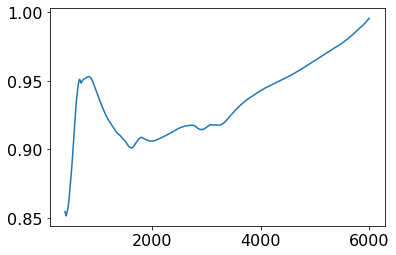

In [382]:
MIR_HZO52_RT = smooth_MIR(HZO52_MIR_RT['MIR/HZO_52nm_MIR_MCT.dpt'])

## Plotting all together

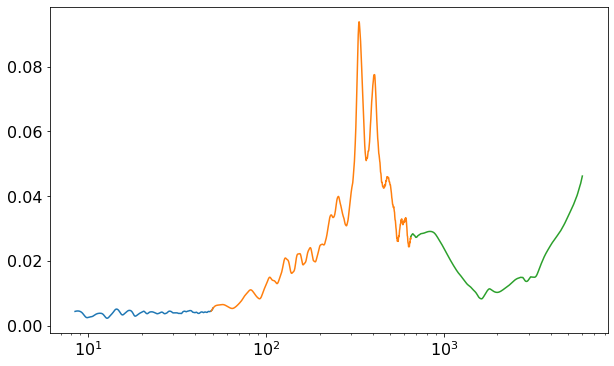

In [383]:
plt.figure(figsize=(10,6))
#THz
start_THz = 70
end_THz = 418

wvn_THz_52 = HZO_52_THz['THz/17_52_10_nm/HZO_52_THz.dpt'].Frequency[start_THz:end_THz]
Abs_THz_52 = ((HZO_52_THz['THz/17_52_10_nm/HZO_52_THz.dpt'].Absorbance[start_THz:end_THz])*0.05+0.005)

plt.plot(wvn_THz_52, Abs_THz_52)

#FIR
start_FIR = 102
end_FIR = -722

wvn_FIR_52 = HZO52_FIR_RT['FIR/HZO_52_RT.txt'].Frequency[start_FIR:end_FIR]
Abs_FIR_52 = HZO52_FIR_RT['FIR/HZO_52_RT.txt'].Absorbance[start_FIR:end_FIR]+0.002
plt.plot(wvn_FIR_52, Abs_FIR_52)

#MIR
start_MIR = 262
end_MIR = len(HZO52_MIR_RT['MIR/HZO_52nm_MIR_MCT.dpt'].Absorbance)

wvn_MIR_52 = HZO52_MIR_RT['MIR/HZO_52nm_MIR_MCT.dpt'].Frequency[start_MIR:end_MIR]
MIR_52_final = MIR_HZO52_RT[start_MIR:end_MIR]*0.4-0.352

plt.plot(wvn_MIR_52, MIR_52_final)

# plt.xlim(10,100)
# plt.ylim(-0.001,0.0025)
plt.xscale(value='log')

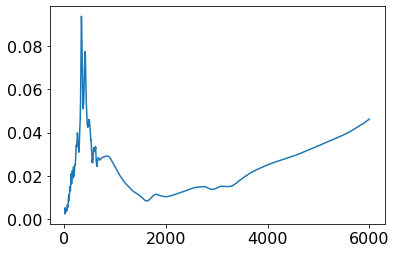

In [388]:
abs_52_all = np.concatenate((Abs_THz_52, Abs_FIR_52, MIR_52_final), axis=0)
wvn_52_all = np.concatenate((wvn_THz_52, wvn_FIR_52, wvn_MIR_52), axis=0)

plt.plot(wvn_52_all, abs_52_all)

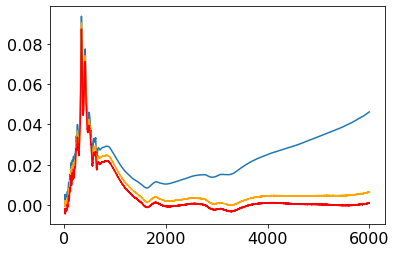

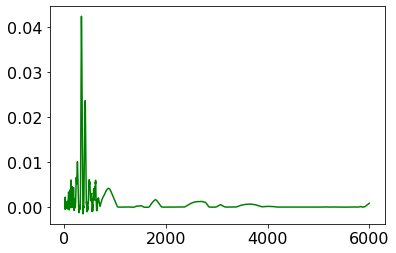

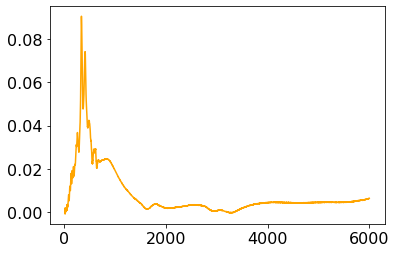

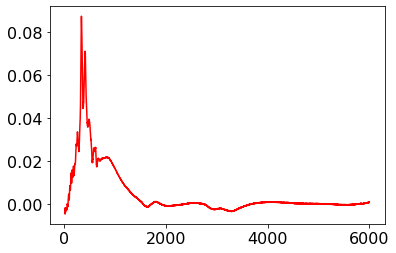

In [389]:
start=0

polynomial_degree=7 #only needed for Modpoly and IModPoly algorithm

baseObj=BaselineRemoval(abs_52_all[start:])

Modpoly_output=baseObj.ModPoly(polynomial_degree)

Imodpoly_output=baseObj.IModPoly(polynomial_degree)

Zhangfit_output=baseObj.ZhangFit()

# print('Original input:',y1)

# print('Modpoly base corrected values:',Modpoly_output)

# print('IModPoly base corrected values:',Imodpoly_output)

# print('ZhangFit base corrected values:',Zhangfit_output)

plt.plot(wvn_52_all, abs_52_all[start:])
plt.plot(wvn_52_all[start:], Modpoly_output, c='orange')
plt.plot(wvn_52_all[start:], Imodpoly_output, c='red')
plt.show()
plt.plot(wvn_52_all[start:], Zhangfit_output, c='green')

plt.show()
plt.plot(wvn_52_all[start:], Modpoly_output, c='orange')

plt.show()
plt.plot(wvn_52_all[start:], Imodpoly_output, c='red')

plt.show()
# plt.plot(HZO11_MIR_RT['MIR/HZO_11nm_MIR_MCT.txt'].Frequency, MIR_11_sm)

# # plt.xlim(655,660)
# plt.ylim(0,0.005)
# plt.xscale(value='log')

(596, 2)


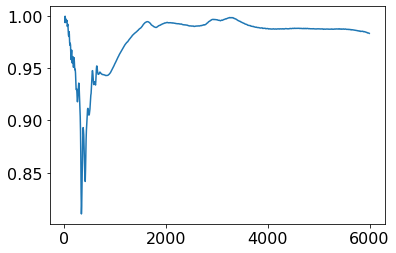

In [390]:
T = 10**(-Modpoly_output-0.0009)

start = 0
step = 12

HZO_52_all_test = np.concatenate((wvn_52_all[start::step].reshape(len(wvn_52_all[start::step]),1),
                                   T[start::step].reshape(len(T[start::step]), 1)), axis=1)

print(HZO_52_all_test.shape)

plt.plot(HZO_52_all_test[:,0], HZO_52_all_test[:,1])
# plt.ylim(0.98,1)

In [ ]:
with open("HZO_52_Reffit_all.txt", 'w') as txt:
    np.savetxt(txt, HZO_52_all_test, delimiter=' ', newline='\n')

# REFFIT
- thickness 1.1e-06
- angle of incidence 80
- scalling factor of T 1
- E_static = 27

# REFFIT Results

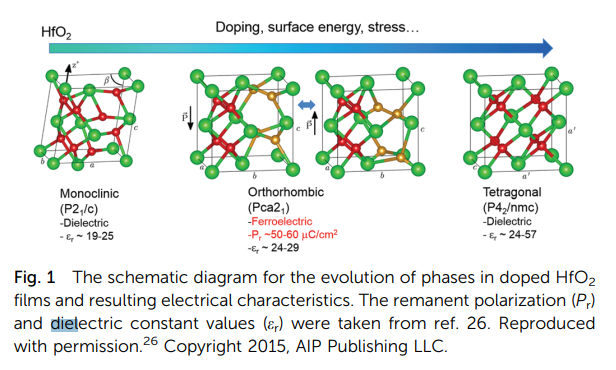

## Functions to treat data from Reffit

In [414]:
def open_reffit_data (local):
    epsilon = pd.read_csv(f'REFFIT/{local}/epsilon_real_imag_logscale2.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "E1", "E2"], header=None)

    sigma = pd.read_csv(f'REFFIT/{local}/sigma_real_imag_logscale.txt', delim_whitespace=True, index_col=False, 
                        names=["Frequency", "sig1", "sig2"], header=None)

    N = pd.read_csv(f'REFFIT/{local}/N1_N2_logscale.txt', delim_whitespace=True, index_col=False, 
                        names=["Frequency", "N1", "N2"], header=None)

    data = pd.read_csv(f'REFFIT/{local}/data.txt', delim_whitespace=True, index_col=False, 
                        names=["Frequency", "Transmitance"], header=None)

    fit = pd.read_csv(f'REFFIT/{local}/fit_logscale.txt', delim_whitespace=True, index_col=False, 
                        names=["Frequency", "Transmitance"], header=None)
    return data, fit, epsilon, N, sigma 

In [415]:
data, HZO_21_fit, HZO_21_epsilon, HZO_21_N ,HZO_21_sigma = open_reffit_data('HZO_21_THz_FIR_MIR_RT')

In [416]:
def plotting_optical_prop (name_data, data_HZO, fit, epsilon, refrac_index, sigma, freq_beg=1, step_fit = 4, 
                           shift_multiply_epsilon=-0.3, shift_multiply_N=-0.5, shift_sum_E=6, shift_sum_N=0.95,
                              start_E2 = 449,    stop_E2 = 1120, start2_E2 = 0,     stop2_E2 = 220):
    
    fig, ax = plt.subplots(2,2, sharex=True)

    ########### plot fit + data ##############################
    

    ax[0,0].plot(data_HZO.Frequency, data_HZO.Transmitance, linewidth=2, label=name_data)
    ax[0,0].plot(fit.Frequency[::step_fit], fit.Transmitance[::step_fit], 
                 linestyle='dashed', marker='o', markersize=0.2, label='fit')
    ax[0,0].set_xscale('log')
    # ax[0,0].set_ylim(-0.005, 0.1)
    ax[0,0].set_xlim(freq_beg, 5000)
    ax[0,0].tick_params(axis='x', direction='in', which='both')
    ax[0,0].set_ylabel(r'Transmitance (a.u.)' , fontsize=12, labelpad=1)
    ax[0,0].legend()



    ########### Function dielectric ##########################
    ax[0,1].plot(epsilon.Frequency, epsilon.E1, label='$\epsilon_1$')
    # ax[0,1].plot(epsilon.Frequency, epsilon.E2)

    # ax[0,1].plot(epsilon.Frequency[start_E2:stop_E2], epsilon.E2[start_E2:stop_E2]*(-0.3)+6)

    test_E2 = np.concatenate((epsilon.E2[start2_E2:stop2_E2], epsilon.E2[start2_E2:stop2_E2+(start_E2-2*stop2_E2)]), axis=0)
    # print(test_E2.shape)

    # ax[0,1].plot(epsilon.Frequency[start2:len(test_E2)], test_E2)
     
    final_E2 = np.concatenate((test_E2, epsilon.E2[start_E2:stop_E2]*(shift_multiply_epsilon)+(shift_sum_E), 
                               epsilon.E2[stop_E2:]),axis=0)
    # print(final_E2.shape)
    ax[0,1].plot(epsilon.Frequency, final_E2, label='$\epsilon_2$')
    ax[0,1].set_xscale('log')
    ax[0,1].set_xlim(freq_beg, 5000)
    ax[0,1].legend()
    ax[0,1].tick_params(axis='x', direction='in', which='both')


    ############ Refraction Index ##########################
    ax[1,0].plot(refrac_index.Frequency, refrac_index.N1, label='$n$')
    # ax[1,0].plot(refrac_index.Frequency, refrac_index.N2)

    start = 440
    stop = 1120
    # ax[1,0].plot(refrac_index.Frequency[start:stop], refrac_index.N2[start:stop]*(-0.5)+0.95)

    start2 = 0
    stop2 = 220
    test = np.concatenate((refrac_index.N2[start2:stop2], refrac_index.N2[start2:stop2]), axis=0)

    # ax[1,0].plot(refrac_index.Frequency[start2:len(test)], test)

    final_N2 = np.concatenate((test, refrac_index.N2[start:stop]*(shift_multiply_N)+(shift_sum_N), 
                               refrac_index.N2[stop:]),axis=0)
    ax[1,0].plot(refrac_index.Frequency, final_N2, label='$k$')
    ax[1,0].set_xscale('log')
    ax[1,0].set_xlim(freq_beg, 5000)

    ax[1,0].tick_params(axis='x', direction='in', which='both')
    ax[1,0].legend()

    ############# Conductivity ##########################
    ax[1,1].plot(sigma.Frequency, sigma.sig1, label='$ \sigma_1$')
    ax[1,1].plot(sigma.Frequency, sigma.sig2, label='$ \sigma_2$')
    ax[1,1].set_xscale('log')
    ax[1,1].set_xlim(freq_beg, 5000)
    ax[1,1].set_ylim(-250, 160)
    ax[1,1].tick_params(axis='x', direction='in', which='both')
    ax[1,1].set_ylabel(r'$Ω^{-1} \cdot cm ^{-1} \times 10^2$' , fontsize=12, labelpad=-4)
    ax[1,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    ax[1,1].yaxis.offsetText.set_visible(False)
    ax[1,1].legend()

    fig.text(0.44, 0.13, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 14)
    # fig.text(0.0, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 14)
    plt.rcParams.update({'font.size': 12})
    fig.set_size_inches(11.5, 7.5)

    plt.subplots_adjust(left=0.1,
                        bottom=0.2, 
                        right=0.8, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.05)
    fig.savefig("Fig_REFFIT_results"+name_data+".png", bbox_inches="tight")

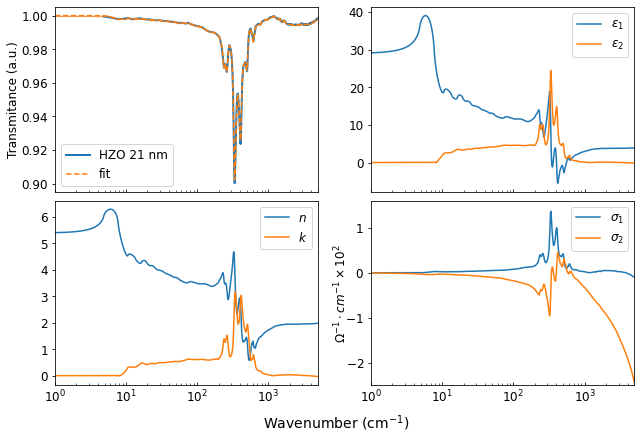

In [417]:
#voir si les fonctions marchent

plotting_optical_prop('HZO 21 nm', data, HZO_21_fit, HZO_21_epsilon, HZO_21_N, HZO_21_sigma)

In [689]:
def plotting_optical_prop_noshift (name_data, data_HZO, fit, epsilon, refrac_index, sigma, freq_beg=1, step_fit = 4, 
                           shift_multiply_epsilon=-0.3, shift_multiply_N=-0.5, shift_sum_E=6, shift_sum_N=0.95,
                              start_E2 = 449,    stop_E2 = 1120, start2_E2 = 0,     stop2_E2 = 220):
    
    fig, ax = plt.subplots(2,2, sharex=True)

    ########### plot fit + data ##############################
    

    ax[0,0].plot(data_HZO.Frequency, data_HZO.Transmitance, linewidth=2, label=name_data)
    ax[0,0].plot(fit.Frequency[::step_fit], fit.Transmitance[::step_fit], 
                 linestyle='dashed', marker='o', markersize=0.2, label='fit')
    ax[0,0].set_xscale('log')
    # ax[0,0].set_ylim(-0.005, 0.1)
    ax[0,0].set_xlim(freq_beg, 5000)
    ax[0,0].tick_params(axis='x', direction='in', which='both')
    ax[0,0].set_ylabel(r'Transmitance (a.u.)' , fontsize=12, labelpad=1)
    ax[0,0].legend()



    ########### Function dielectric ##########################
    ax[0,1].plot(epsilon.Frequency, epsilon.E1, label='$\epsilon_1$')
    ax[0,1].plot(epsilon.Frequency, epsilon.E2, label='$\epsilon_2$')
    ax[0,1].set_xscale('log')
    ax[0,1].set_xlim(freq_beg, 5000)
    ax[0,1].legend()
    ax[0,1].tick_params(axis='x', direction='in', which='both')


    ############ Refraction Index ##########################
    ax[1,0].plot(refrac_index.Frequency, refrac_index.N1, label='$n$')
    ax[1,0].plot(refrac_index.Frequency, refrac_index.N2, label='$k$')
    ax[1,0].set_xscale('log')
    ax[1,0].set_xlim(freq_beg, 5000)
    ax[1,0].tick_params(axis='x', direction='in', which='both')
    ax[1,0].legend()

    ############# Conductivity ##########################
    ax[1,1].plot(sigma.Frequency, sigma.sig1, label='$ \sigma_1$')
    ax[1,1].plot(sigma.Frequency, sigma.sig2, label='$ \sigma_2$')
    ax[1,1].set_xscale('log')
    ax[1,1].set_xlim(freq_beg, 5000)
    ax[1,1].set_ylim(-250, 160)
    ax[1,1].tick_params(axis='x', direction='in', which='both')
    ax[1,1].set_ylabel(r'$Ω^{-1} \cdot cm ^{-1} \times 10^2$' , fontsize=12, labelpad=-4)
    ax[1,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    ax[1,1].yaxis.offsetText.set_visible(False)
    ax[1,1].legend()

    fig.text(0.44, 0.13, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 14)
    # fig.text(0.0, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 14)
    plt.rcParams.update({'font.size': 12})
    fig.set_size_inches(11.5, 7.5)

    plt.subplots_adjust(left=0.1,
                        bottom=0.2, 
                        right=0.8, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.05)
    fig.savefig("Fig_REFFIT_results"+name_data+".png", bbox_inches="tight")

In [844]:
def fixing_E2(name_epsilon, shift_sum, shift_multi, start1= 485, stop1= 905):

    # plotting original
    name_epsilon.plot("Frequency", 'E2')
    plt.xscale(value='log')
    # plt.xlim(40,70)

    #printing values of the range we want to change
    print(name_epsilon.Frequency[start1])
    print(name_epsilon.Frequency[stop1])

    # editing the range we want to change
    piece = name_epsilon.E2[start1:stop1]*(shift_multi)+shift_sum
    plt.plot(name_epsilon.Frequency[start1:stop1], piece)

    # putting all the y range together
    test = np.concatenate((name_epsilon.E2[:start1], piece, name_epsilon.E2[stop1:]), axis=0)

    # we observe that there is still points thata are  weird
    plt.plot(name_epsilon.Frequency, test)
    
    #adds new test column to original df
    name_epsilon["test"] = test
    
    return name_epsilon

In [889]:
def fixing_N2(name_N, shift_sum, shift_multi, start1= 485, stop1= 905):    

    # plotting original
    name_N.plot("Frequency", 'N2')
    plt.xscale(value='log')
    # plt.xlim(40,70)

    #printing values of the range we want to change
    print(name_N.Frequency[start1])
    print(name_N.Frequency[stop1])

    # editing the range we want to change
    piece = name_N.N2[start1:stop1]*(shift_multi)+shift_sum
    plt.plot(name_N.Frequency[start1:stop1], piece)

    # putting all the y range together
    test = np.concatenate((name_N.N2[:start1], piece, name_N.N2[stop1:]), axis=0)

    # we observe that there is still points thata are  weird
    plt.plot(name_N.Frequency, test)
    plt.show()
    plt.plot(name_N.Frequency, test)
    plt.xlim(0, 50)
    
    #adds new test column to original df
    name_N["test"] = test
    
    return name_N

## 21nm

In [367]:
HZO_21_epsilon = pd.read_csv('REFFIT/HZO_21_THz_FIR_MIR_RT/epsilon_real_imag_logscale2.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "E1", "E2"], header=None)

HZO_21_sigma = pd.read_csv('REFFIT/HZO_21_THz_FIR_MIR_RT/sigma_real_imag_logscale.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "sig1", "sig2"], header=None)

HZO_21_N = pd.read_csv('REFFIT/HZO_21_THz_FIR_MIR_RT/N1_N2_logscale.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "N1", "N2"], header=None)

HZO_21_data = pd.read_csv('REFFIT/HZO_21_THz_FIR_MIR_RT/HZO_21_Reffit_all.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Transmitance"], header=None)

HZO_21_fit = pd.read_csv('REFFIT/HZO_21_THz_FIR_MIR_RT/fit_logscale.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Transmitance"], header=None)

In [368]:
HZO_21_N.Frequency[1120]

197.131

In [369]:
HZO_21_epsilon["E1"]

0       29.14080
1       29.14220
2       29.14350
3       29.14490
4       29.14630
          ...   
1848     4.01598
1849     4.01423
1850     4.01265
1851     4.01120
1852     4.00988
Name: E1, Length: 1853, dtype: float64

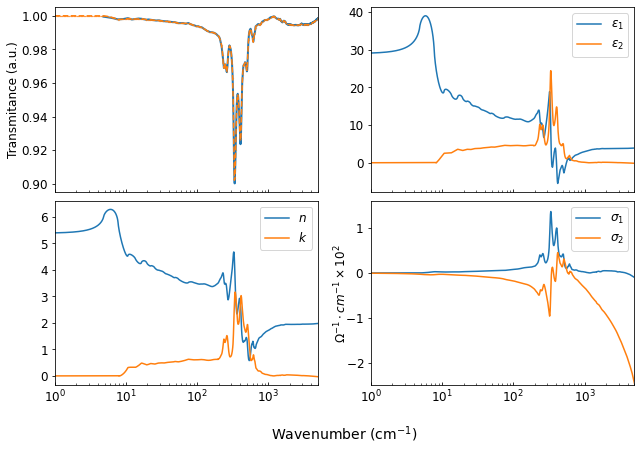

In [371]:
fig, ax = plt.subplots(2,2, sharex=True)


freq_beg = 1

########### plot fit + data ##############################
step_fit = 4

ax[0,0].plot(HZO_21_data.Frequency, HZO_21_data.Transmitance, linewidth=2)
ax[0,0].plot(HZO_21_fit.Frequency[::step_fit], HZO_21_fit.Transmitance[::step_fit], 
             linestyle='dashed', marker='o', markersize=0.2)
ax[0,0].set_xscale('log')
# ax[0,0].set_ylim(-0.005, 0.1)
ax[0,0].set_xlim(freq_beg, 5000)
ax[0,0].tick_params(axis='x', direction='in', which='both')
ax[0,0].set_ylabel(r'Transmitance (a.u.)' , fontsize=12, labelpad=1)




########### Function dielectric ##########################
ax[0,1].plot(HZO_21_epsilon.Frequency, HZO_21_epsilon.E1, label='$\epsilon_1$')
# ax[0,1].plot(HZO_21_epsilon.Frequency, HZO_21_epsilon.E2)

start_E2 = 449
stop_E2 = 1120
# ax[0,1].plot(HZO_21_epsilon.Frequency[start_E2:stop_E2], HZO_21_epsilon.E2[start_E2:stop_E2]*(-0.3)+6)

start2_E2 = 0
stop2_E2 = 220
test_E2 = np.concatenate((HZO_21_epsilon.E2[start2_E2:stop2_E2], HZO_21_epsilon.E2[start2_E2:stop2_E2+9]), axis=0)
# print(test_E2.shape)

# ax[0,1].plot(HZO_21_epsilon.Frequency[start2:len(test_E2)], test_E2)

final_E2 = np.concatenate((test_E2, HZO_21_epsilon.E2[start_E2:stop_E2]*(-0.3)+6, HZO_21_epsilon.E2[stop_E2:]),axis=0)
# print(final_E2.shape)
ax[0,1].plot(HZO_21_epsilon.Frequency, final_E2, label='$\epsilon_2$')
ax[0,1].set_xscale('log')
ax[0,1].set_xlim(freq_beg, 5000)
ax[0,1].legend()
ax[0,1].tick_params(axis='x', direction='in', which='both')


############ Refraction Index ##########################
ax[1,0].plot(HZO_21_N.Frequency, HZO_21_N.N1, label='$n$')
# ax[1,0].plot(HZO_21_N.Frequency, HZO_21_N.N2)

start = 440
stop = 1120
# ax[1,0].plot(HZO_21_N.Frequency[start:stop], HZO_21_N.N2[start:stop]*(-0.5)+0.95)

start2 = 0
stop2 = 220
test = np.concatenate((HZO_21_N.N2[start2:stop2], HZO_21_N.N2[start2:stop2]), axis=0)

# ax[1,0].plot(HZO_21_N.Frequency[start2:len(test)], test)

final_N2 = np.concatenate((test, HZO_21_N.N2[start:stop]*(-0.5)+0.95, HZO_21_N.N2[stop:]),axis=0)
ax[1,0].plot(HZO_21_N.Frequency, final_N2, label='$k$')
ax[1,0].set_xscale('log')
ax[1,0].set_xlim(freq_beg, 5000)

ax[1,0].tick_params(axis='x', direction='in', which='both')
ax[1,0].legend()

############# Conductivity ##########################
ax[1,1].plot(HZO_21_sigma.Frequency, HZO_21_sigma.sig1, label='$ \sigma_1$')
ax[1,1].plot(HZO_21_sigma.Frequency, HZO_21_sigma.sig2, label='$ \sigma_2$')
ax[1,1].set_xscale('log')
ax[1,1].set_xlim(freq_beg, 5000)
ax[1,1].set_ylim(-250, 160)
ax[1,1].tick_params(axis='x', direction='in', which='both')
ax[1,1].set_ylabel(r'$Ω^{-1} \cdot cm ^{-1} \times 10^2$' , fontsize=12, labelpad=-4)
ax[1,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax[1,1].yaxis.offsetText.set_visible(False)
ax[1,1].legend()

# fig.text(0.45, 0.92, 'HZO 21 nm', fontsize = 17, ha='center', va='center')
fig.text(0.45, 0.11, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 14)
# fig.text(0.0, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 14)
plt.rcParams.update({'font.size': 12})
fig.set_size_inches(11.5, 7.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.2, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.05)

## 11 nm

In [1071]:
HZO_11_epsilon = pd.read_csv('REFFIT/HZO_11_THz_FIR_MIR_RT/epsilon_real_imag_logscale.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "E1", "E2"], header=None)

HZO_11_sigma = pd.read_csv('REFFIT/HZO_11_THz_FIR_MIR_RT/sigma_real_imag_logscale.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "sig1", "sig2"], header=None)

HZO_11_N = pd.read_csv('REFFIT/HZO_11_THz_FIR_MIR_RT/N1_N2_logscale.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "N1", "N2"], header=None)

HZO_11_data = pd.read_csv('REFFIT/HZO_11_THz_FIR_MIR_RT/HZO_11_Reffit_all.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Transmitance"], header=None)

HZO_11_fit = pd.read_csv('REFFIT/HZO_11_THz_FIR_MIR_RT/fit_logscale.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Transmitance"], header=None)

In [ ]:
HZO_11_epsilon['E1']

## 21 nm - 736 K
#### déjà commencé sur REFFIT mais il manque le MIR pour continuer

## 10 nm - RT

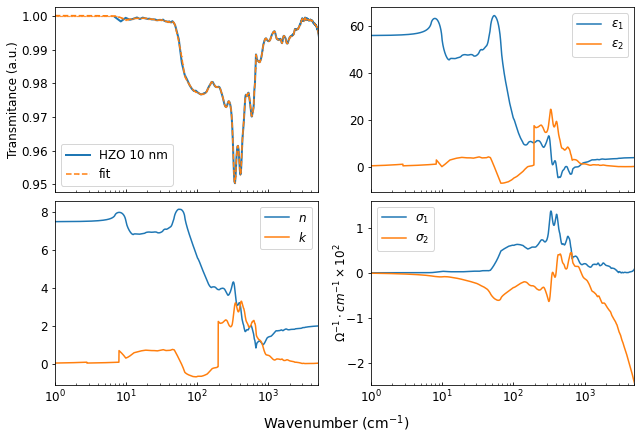

In [721]:
data, HZO_10_fit, HZO_10_epsilon, HZO_10_N ,HZO_10_sigma = open_reffit_data('HZO_10_THz_FIR_MIR_RT')

plotting_optical_prop('HZO 10 nm', data, HZO_10_fit, HZO_10_epsilon, HZO_10_N, HZO_10_sigma)

In [1165]:
HZO_10_epsilon

,Frequency,E1,E2_orig,E2
0,1.00000,56.09610,0.377282,0.377282
1,1.00472,56.09650,0.379063,0.379063
2,1.00946,56.09680,0.380852,0.380852
3,1.01422,56.09720,0.382649,0.382649
4,1.01901,56.09760,0.384455,0.384455
...,...,...,...,...
1844,5888.08000,3.85030,0.001657,0.001657
1845,5915.86000,3.85370,0.001634,0.001634
1846,5943.77000,3.85689,0.001610,0.001610
1847,5971.82000,3.85988,0.001587,0.001587


#### Trying to fix E2

In [732]:
data, HZO_10_fit, HZO_10_epsilon, HZO_10_N ,HZO_10_sigma = open_reffit_data('HZO_10_THz_FIR_MIR_RT')

9.80754
70.8322


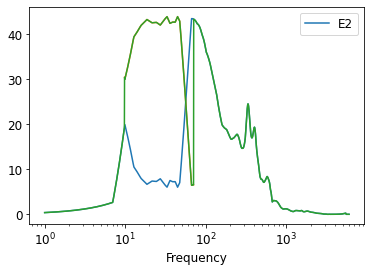

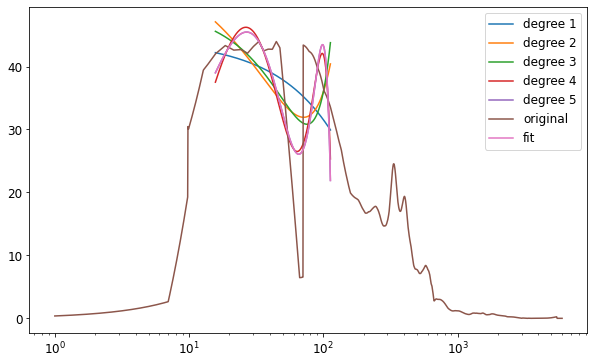

In [733]:
# Trying to fix the E2

from scipy.interpolate import interp1d

start1 = 485
stop1 = 905

# plotting original
HZO_10_epsilon.plot("Frequency", 'E2')
plt.xscale(value='log')
# plt.xlim(40,70)

#printing values of the range we want to change
print(HZO_10_epsilon.Frequency[start1])
print(HZO_10_epsilon.Frequency[stop1])

# editing the range we want to change
piece = HZO_10_epsilon.E2[start1:stop1]*(-1)+50
plt.plot(HZO_10_epsilon.Frequency[start1:stop1], piece)

# putting all the y range together
test = np.concatenate((HZO_10_epsilon.E2[:start1], piece, HZO_10_epsilon.E2[stop1:]), axis=0)

# we observe that there is still points thata are  weird
plt.plot(HZO_10_epsilon.Frequency, test)

# f = interp1d(HZO_10_epsilon.Frequency, test, kind='cubic')

# i try many things to try to fix these points that are down - NOTHING WORKS
# plt.scatter(HZO_10_epsilon.Frequency, f(HZO_10_epsilon.Frequency))
start = 585
stop = 1005

X = HZO_10_epsilon.Frequency[start:stop].values.reshape(len(HZO_10_epsilon.Frequency[start:stop]), 1)
y = test[start:stop].reshape(len(test[start:stop]),1)
# polynomial features
fig, ax = plt.subplots(figsize=(10,6))

for degree in [1,2, 3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X, y)
    y_plot = model.predict(X)
    ax.plot(X, y_plot, label=f"degree {degree}")

ax.plot(HZO_10_epsilon.Frequency, test, label='original')
ax.plot(X, y_plot, label='fit')
ax.set_xscale(value='log')
# ax.set_ylim(0.97,1.005)

ax.legend()

In [735]:
# fixing points that are down 
# adding the test column to the df
HZO_10_epsilon["test"] = test

# putting the weird value equals to one average value
HZO_10_epsilon.test[821:905] = 42.53
HZO_10_epsilon.head()

,Frequency,E1,E2,test
0,1.00000,56.0961,0.377282,0.377282
1,1.00472,56.0965,0.379063,0.379063
2,1.00946,56.0968,0.380852,0.380852
3,1.01422,56.0972,0.382649,0.382649
4,1.01901,56.0976,0.384455,0.384455


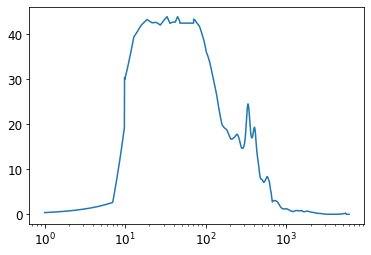

In [728]:
# plotting to see how it looks
plt.plot(HZO_10_epsilon.Frequency, HZO_10_epsilon.test)
plt.xscale(value='log')

In [736]:
# renaming the good columns so I can use the plotting_opt_func function
HZO_10_epsilon.rename(columns={"E2":"E2_orig", "test":"E2"}, inplace=True)
HZO_10_epsilon

,Frequency,E1,E2_orig,E2
0,1.00000,56.09610,0.377282,0.377282
1,1.00472,56.09650,0.379063,0.379063
2,1.00946,56.09680,0.380852,0.380852
3,1.01422,56.09720,0.382649,0.382649
4,1.01901,56.09760,0.384455,0.384455
...,...,...,...,...
1844,5888.08000,3.85030,0.001657,0.001657
1845,5915.86000,3.85370,0.001634,0.001634
1846,5943.77000,3.85689,0.001610,0.001610
1847,5971.82000,3.85988,0.001587,0.001587


#### Trying to fix k

In [755]:
data, HZO_10_fit, pas_utiliser_E, HZO_10_N ,HZO_10_sigma = open_reffit_data('HZO_10_THz_FIR_MIR_RT')

In [756]:
HZO_10_N.head()

,Frequency,N1,N2
0,1.00000,7.48977,0.025187
1,1.00473,7.48980,0.025306
2,1.00948,7.48982,0.025425
3,1.01425,7.48985,0.025545
4,1.01905,7.48987,0.025666


9.85624
86.3376


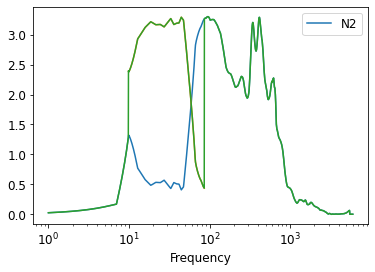

In [757]:
start1 = 485
stop1 = 945

# plotting original
HZO_10_N.plot("Frequency", 'N2')
plt.xscale(value='log')
# plt.xlim(40,70)

#printing values of the range we want to change
print(HZO_10_N.Frequency[start1])
print(HZO_10_N.Frequency[stop1])

# editing the range we want to change
piece = HZO_10_N.N2[start1:stop1]*(-1)+3.7
plt.plot(HZO_10_N.Frequency[start1:stop1], piece)

# putting all the y range together
test = np.concatenate((HZO_10_N.N2[:start1], piece, HZO_10_N.N2[stop1:]), axis=0)

# we observe that there is still points thata are  weird
plt.plot(HZO_10_N.Frequency, test)

In [758]:
# fixing points that are down
HZO_10_N["test"] = test
HZO_10_N.head()

,Frequency,N1,N2,test
0,1.00000,7.48977,0.025187,0.025187
1,1.00473,7.48980,0.025306,0.025306
2,1.00948,7.48982,0.025425,0.025425
3,1.01425,7.48985,0.025545,0.025545
4,1.01905,7.48987,0.025666,0.025666


In [759]:
HZO_10_N[821:905]

,Frequency,N1,N2,test
821,48.0992,7.81518,0.529580,3.170420
822,48.3267,7.84098,0.557193,3.142807
823,48.5552,7.86451,0.584948,3.115052
824,48.7848,7.88623,0.612831,3.087169
825,49.0155,7.90645,0.640837,3.059163
...,...,...,...,...
900,69.8233,7.37508,2.946840,0.753160
901,70.1534,7.34550,2.957620,0.742380
902,70.4852,7.31652,2.968120,0.731880
903,70.8185,7.28806,2.978350,0.721650


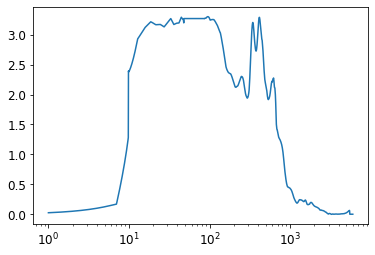

In [760]:
# putting the weird value equals to one average value
HZO_10_N.test[821:945] = 3.27
HZO_10_N.head()

plt.plot(HZO_10_N.Frequency, HZO_10_N.test)
plt.xscale(value='log')

In [761]:
HZO_10_N.head()

,Frequency,N1,N2,test
0,1.00000,7.48977,0.025187,0.025187
1,1.00473,7.48980,0.025306,0.025306
2,1.00948,7.48982,0.025425,0.025425
3,1.01425,7.48985,0.025545,0.025545
4,1.01905,7.48987,0.025666,0.025666


In [762]:
HZO_10_N.rename(columns={"N2":"N2_orig", "test":"N2"}, inplace=True)
HZO_10_N

,Frequency,N1,N2_orig,N2
0,1.00000,7.48977,0.025187,0.025187
1,1.00473,7.48980,0.025306,0.025306
2,1.00948,7.48982,0.025425,0.025425
3,1.01425,7.48985,0.025545,0.025545
4,1.01905,7.48987,0.025666,0.025666
...,...,...,...,...
1840,5887.84000,1.96221,0.000422,0.000422
1841,5915.68000,1.96308,0.000416,0.000416
1842,5943.65000,1.96389,0.000410,0.000410
1843,5971.76000,1.96466,0.000404,0.000404


#### Plotting final Optical Constants

   Frequency       N1   N2_orig        N2
0    1.00000  7.48977  0.025187  0.025187
1    1.00473  7.48980  0.025306  0.025306
2    1.00948  7.48982  0.025425  0.025425
3    1.01425  7.48985  0.025545  0.025545
4    1.01905  7.48987  0.025666  0.025666
   Frequency       E1   E2_orig        E2
0    1.00000  56.0961  0.377282  0.377282
1    1.00472  56.0965  0.379063  0.379063
2    1.00946  56.0968  0.380852  0.380852
3    1.01422  56.0972  0.382649  0.382649
4    1.01901  56.0976  0.384455  0.384455


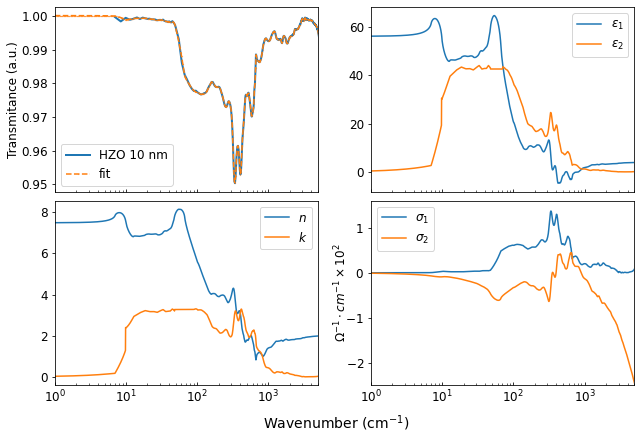

In [1067]:
# I reimport my original data, but I dont use the original E and N
HZO_10_data, HZO_10_fit, pas_utiliser_E, pas_uitiliser_N ,HZO_10_sigma = open_reffit_data('HZO_10_THz_FIR_MIR_RT')

# I import my edited E and N (witht the good E2 and N2, see replace!!)
print(HZO_10_N.head())

print(HZO_10_epsilon.head())

# I plot everything
plotting_optical_prop_noshift('HZO 10 nm', HZO_10_data, HZO_10_fit, HZO_10_epsilon, HZO_10_N, HZO_10_sigma,
                            freq_beg=1, step_fit = 4, 
                            shift_multiply_epsilon=-1, 
                            shift_multiply_N=0.5, 
                            shift_sum_E=50, 
                            shift_sum_N=0.95,
                            start_E2 = 500,    
                            stop_E2 = 815, 
                            start2_E2 = 0,     
                            stop2_E2 = 1
                     )

## 17 nm - RT

In [433]:
data, HZO_17_fit, HZO_17_epsilon, HZO_17_N ,HZO_17_sigma = open_reffit_data('HZO_17_THz_FIR_MIR_RT')

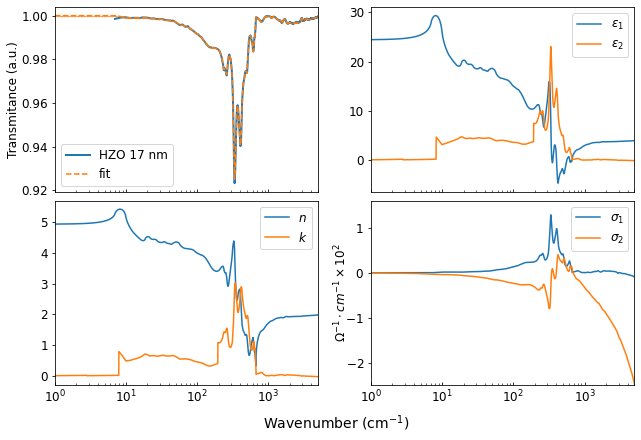

In [434]:
plotting_optical_prop('HZO 17 nm', data, HZO_17_fit, HZO_17_epsilon, HZO_17_N ,HZO_17_sigma)

#### Trying to fix E2 

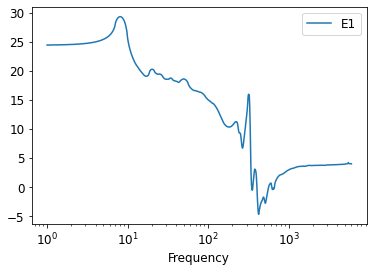

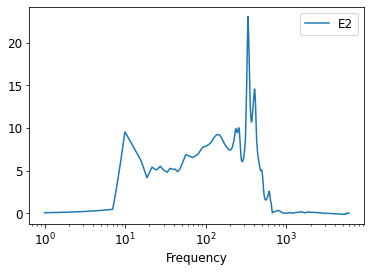

In [932]:
data, HZO_17_fit, HZO_17_epsilon, pas_utiliser ,HZO_17_sigma = open_reffit_data('HZO_17_THz_FIR_MIR_RT')

HZO_17_epsilon.plot("Frequency", "E1")
plt.xscale(value='log')
HZO_17_epsilon.plot("Frequency", "E2")
plt.xscale(value='log')

8.67796
18.8375


,Frequency,E1,E2,test
0,1.00000,24.44240,0.067050,0.067050
1,1.00471,24.44270,0.067365,0.067365
2,1.00944,24.44300,0.067683,0.067683
3,1.01419,24.44330,0.068001,0.068001
4,1.01897,24.44360,0.068322,0.068322
...,...,...,...,...
1848,5888.32000,4.01646,0.000445,0.000445
1849,5916.04000,4.01493,0.000439,0.000439
1850,5943.90000,4.01353,0.000433,0.000433
1851,5971.88000,4.01224,0.000427,0.000427


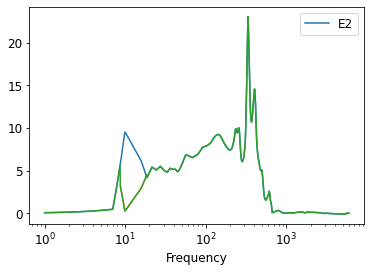

In [933]:
data, HZO_17_fit, HZO_17_epsilon, HZO_17_N ,HZO_17_sigma = open_reffit_data('HZO_17_THz_FIR_MIR_RT')

fixing_E2(HZO_17_epsilon, 7.8, -0.79, start1=460, stop1=625)

In [934]:
HZO_17_epsilon.test[400:495] = 0.44
HZO_17_epsilon

,Frequency,E1,E2,test
0,1.00000,24.44240,0.067050,0.067050
1,1.00471,24.44270,0.067365,0.067365
2,1.00944,24.44300,0.067683,0.067683
3,1.01419,24.44330,0.068001,0.068001
4,1.01897,24.44360,0.068322,0.068322
...,...,...,...,...
1848,5888.32000,4.01646,0.000445,0.000445
1849,5916.04000,4.01493,0.000439,0.000439
1850,5943.90000,4.01353,0.000433,0.000433
1851,5971.88000,4.01224,0.000427,0.000427


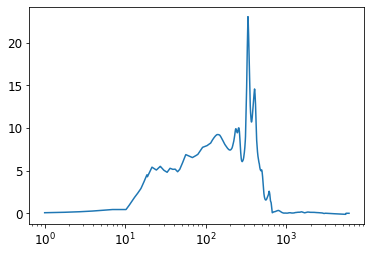

In [935]:
# plotting to see how it looks
plt.plot(HZO_17_epsilon.Frequency, HZO_17_epsilon.test)
plt.xscale(value='log')

In [936]:
# renaming the good columns so I can use the plotting_opt_func function
HZO_17_epsilon.rename(columns={"E2":"E2_orig", "test":"E2"}, inplace=True)
HZO_17_epsilon

,Frequency,E1,E2_orig,E2
0,1.00000,24.44240,0.067050,0.067050
1,1.00471,24.44270,0.067365,0.067365
2,1.00944,24.44300,0.067683,0.067683
3,1.01419,24.44330,0.068001,0.068001
4,1.01897,24.44360,0.068322,0.068322
...,...,...,...,...
1848,5888.32000,4.01646,0.000445,0.000445
1849,5916.04000,4.01493,0.000439,0.000439
1850,5943.90000,4.01353,0.000433,0.000433
1851,5971.88000,4.01224,0.000427,0.000427


#### Trying to fix N2 

8.71864
18.9576


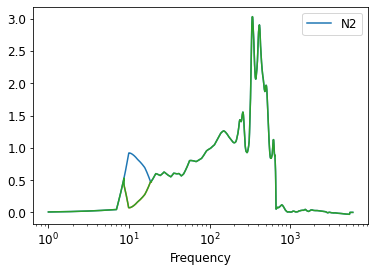

,Frequency,N1,N2,test
0,1.00000,4.94393,0.006781,0.006781
1,1.00472,4.94396,0.006813,0.006813
2,1.00946,4.94399,0.006845,0.006845
3,1.01422,4.94402,0.006877,0.006877
4,1.01901,4.94405,0.006910,0.006910
...,...,...,...,...
1844,5888.08000,2.00412,0.000111,0.000111
1845,5915.86000,2.00373,0.000110,0.000110
1846,5943.77000,2.00338,0.000108,0.000108
1847,5971.82000,2.00306,0.000107,0.000107


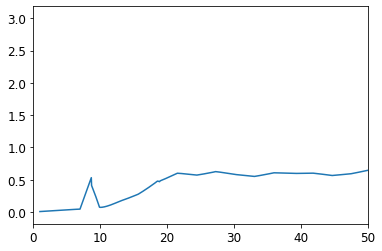

In [946]:
data, HZO_17_fit, pas_utiliser, HZO_17_N ,HZO_17_sigma = open_reffit_data('HZO_17_THz_FIR_MIR_RT')

fixing_N2(HZO_17_N, 0.9, -0.9, start1=460, stop1=625)

In [947]:
HZO_17_N.test[416:495] = 0.07

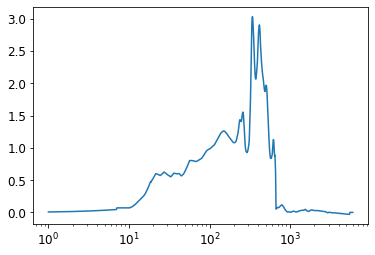

In [948]:
# plotting to see how it looks
plt.plot(HZO_17_N.Frequency, HZO_17_N.test)
plt.xscale(value='log')

In [949]:
# renaming the good columns so I can use the plotting_opt_func function
HZO_17_N.rename(columns={"N2":"N2_orig", "test":"N2"}, inplace=True)

#### Plotting all together

   Frequency       N1   N2_orig        N2
0    1.00000  4.94393  0.006781  0.006781
1    1.00472  4.94396  0.006813  0.006813
2    1.00946  4.94399  0.006845  0.006845
3    1.01422  4.94402  0.006877  0.006877
4    1.01901  4.94405  0.006910  0.006910
   Frequency       E1   E2_orig        E2
0    1.00000  24.4424  0.067050  0.067050
1    1.00471  24.4427  0.067365  0.067365
2    1.00944  24.4430  0.067683  0.067683
3    1.01419  24.4433  0.068001  0.068001
4    1.01897  24.4436  0.068322  0.068322


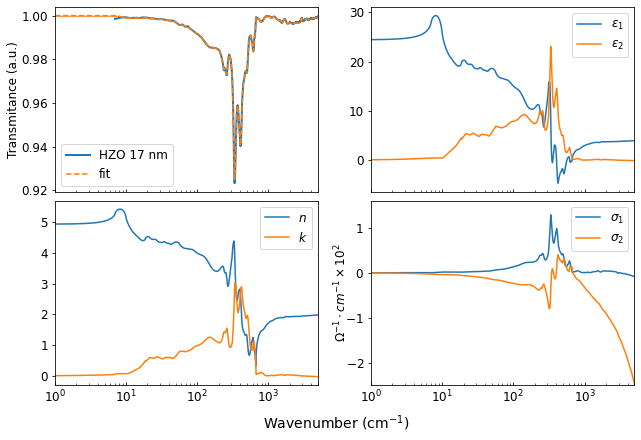

In [1065]:
# I reimport my original data, but I dont use the original E and N
HZO_17_data, HZO_17_fit, pas_utiliser_E, pas_uitiliser_N ,HZO_17_sigma = open_reffit_data('HZO_17_THz_FIR_MIR_RT')

# I import my edited E and N (witht the good E2 and N2, see replace!!)
print(HZO_17_N.head())

print(HZO_17_epsilon.head())

# I plot everything
plotting_optical_prop_noshift('HZO 17 nm', HZO_17_data, HZO_17_fit, HZO_17_epsilon, HZO_17_N, HZO_17_sigma,
                            freq_beg=1, step_fit = 4, 
                            shift_multiply_epsilon=-1, 
                            shift_multiply_N=0.5, 
                            shift_sum_E=50, 
                            shift_sum_N=0.95,
                            start_E2 = 500,    
                            stop_E2 = 815, 
                            start2_E2 = 0,     
                            stop2_E2 = 1
                     )

## 52 nm - RT

In [439]:
data, HZO_52_fit, HZO_52_epsilon, HZO_52_N ,HZO_52_sigma = open_reffit_data('HZO_52_THz_FIR_MIR_RT')

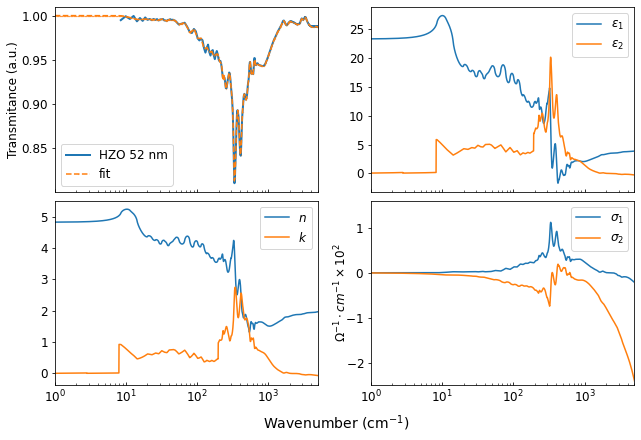

In [440]:
plotting_optical_prop('HZO 52 nm', data, HZO_52_fit, HZO_52_epsilon, HZO_52_N, HZO_52_sigma)

#### Trying to fix E2

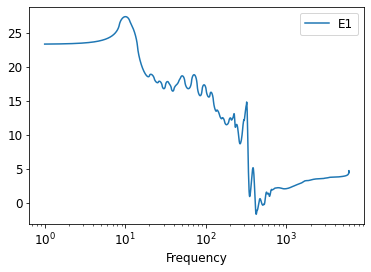

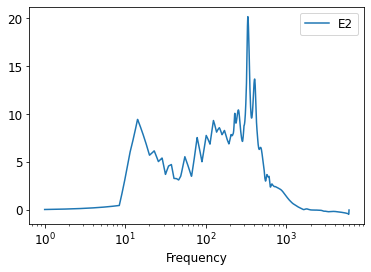

In [951]:
data, HZO_52_fit, HZO_52_epsilon, pas_utiliser ,HZO_52_sigma = open_reffit_data('HZO_52_THz_FIR_MIR_RT')

HZO_52_epsilon.plot("Frequency", "E1")
plt.xscale(value='log')
HZO_52_epsilon.plot("Frequency", "E2")
plt.xscale(value='log')

8.67796
19.7435


,Frequency,E1,E2,test
0,1.00000,23.32970,0.056153,0.056153
1,1.00471,23.32980,0.056417,0.056417
2,1.00944,23.33000,0.056683,0.056683
3,1.01419,23.33020,0.056950,0.056950
4,1.01897,23.33040,0.057218,0.057218
...,...,...,...,...
1848,5888.32000,4.22458,-0.402295,-0.402295
1849,5916.04000,4.28349,-0.418525,-0.418525
1850,5943.90000,4.34224,-0.446773,-0.446773
1851,5971.88000,4.73007,-0.281163,-0.281163


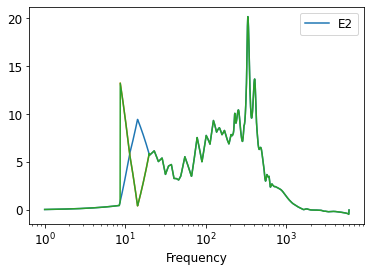

In [1012]:
data, HZO_52_fit, HZO_52_epsilon, pas_utiliser ,HZO_52_sigma = open_reffit_data('HZO_52_THz_FIR_MIR_RT')

fixing_E2(HZO_52_epsilon, 14.6, -1.5, start1=460, stop1=635)

In [1013]:
HZO_52_epsilon.test[455:568] = 0.54

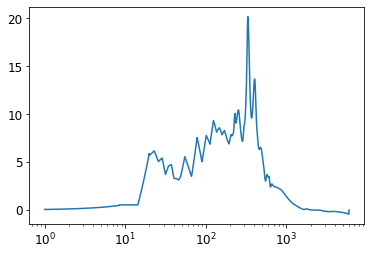

In [1014]:
# plotting to see how it looks
plt.plot(HZO_52_epsilon.Frequency, HZO_52_epsilon.test)
plt.xscale(value='log')

In [1015]:
# renaming the good columns so I can use the plotting_opt_func function
HZO_52_epsilon.rename(columns={"E2":"E2_orig", "test":"E2"}, inplace=True)
HZO_52_epsilon

,Frequency,E1,E2_orig,E2
0,1.00000,23.32970,0.056153,0.056153
1,1.00471,23.32980,0.056417,0.056417
2,1.00944,23.33000,0.056683,0.056683
3,1.01419,23.33020,0.056950,0.056950
4,1.01897,23.33040,0.057218,0.057218
...,...,...,...,...
1848,5888.32000,4.22458,-0.402295,-0.402295
1849,5916.04000,4.28349,-0.418525,-0.418525
1850,5943.90000,4.34224,-0.446773,-0.446773
1851,5971.88000,4.73007,-0.281163,-0.281163


#### Trying to fix N2

8.35603
20.0007


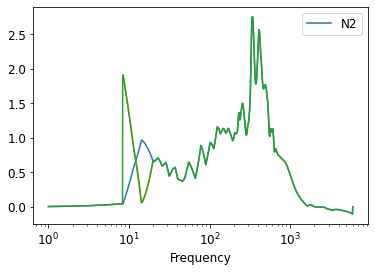

,Frequency,N1,N2,test
0,1.00000,4.83008,0.005813,0.005813
1,1.00473,4.83010,0.005840,0.005840
2,1.00948,4.83012,0.005868,0.005868
3,1.01425,4.83014,0.005896,0.005896
4,1.01905,4.83016,0.005923,0.005923
...,...,...,...,...
1840,5887.84000,2.05752,-0.097726,-0.097726
1841,5915.68000,2.07186,-0.101019,-0.101019
1842,5943.65000,2.08625,-0.106768,-0.106768
1843,5971.76000,2.17577,-0.065263,-0.065263


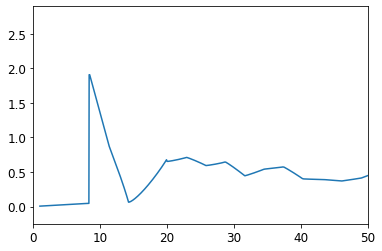

In [1039]:
data, HZO_52_fit, pas_utiliser, HZO_52_N ,HZO_52_sigma = open_reffit_data('HZO_52_THz_FIR_MIR_RT')

fixing_N2(HZO_52_N, 2, -2.0, start1=450, stop1=635)

In [1059]:
HZO_52_N.test[449:562] = 0.05

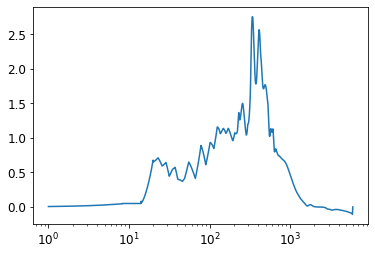

In [1060]:
# plotting to see how it looks
plt.plot(HZO_52_N.Frequency, HZO_52_N.test)
plt.xscale(value='log')

In [1061]:
# renaming the good columns so I can use the plotting_opt_func function
HZO_52_N.rename(columns={"N2":"N2_orig", "test":"N2"}, inplace=True)

#### Plotting all together

   Frequency       N1   N2_orig        N2
0    1.00000  4.83008  0.005813  0.005813
1    1.00473  4.83010  0.005840  0.005840
2    1.00948  4.83012  0.005868  0.005868
3    1.01425  4.83014  0.005896  0.005896
4    1.01905  4.83016  0.005923  0.005923
   Frequency       E1   E2_orig        E2
0    1.00000  23.3297  0.056153  0.056153
1    1.00471  23.3298  0.056417  0.056417
2    1.00944  23.3300  0.056683  0.056683
3    1.01419  23.3302  0.056950  0.056950
4    1.01897  23.3304  0.057218  0.057218


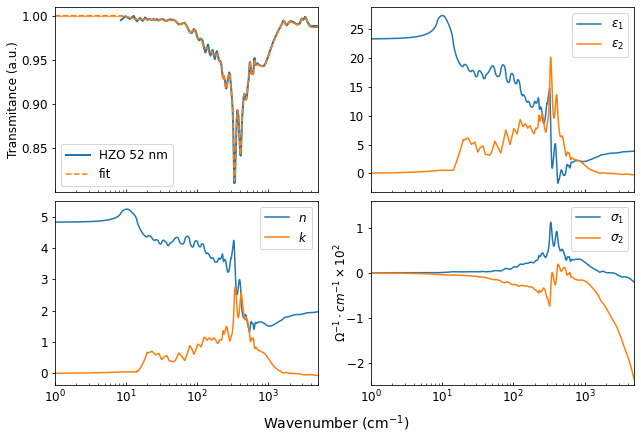

In [1062]:
# I reimport my original data, but I dont use the original E and N
data, HZO_52_fit, pas_utiliser_E, pas_utiliser_N ,HZO_52_sigma = open_reffit_data('HZO_52_THz_FIR_MIR_RT')

# I import my edited E and N (witht the good E2 and N2, see replace!!)
print(HZO_52_N.head())

print(HZO_52_epsilon.head())

# I plot everything
plotting_optical_prop_noshift('HZO 52 nm', data, HZO_52_fit, HZO_52_epsilon, HZO_52_N, HZO_52_sigma,
                            freq_beg=1, step_fit = 4, 
                            shift_multiply_epsilon=-1, 
                            shift_multiply_N=0.5, 
                            shift_sum_E=50, 
                            shift_sum_N=0.95,
                            start_E2 = 500,    
                            stop_E2 = 815, 
                            start2_E2 = 0,     
                            stop2_E2 = 1
                     )

## Plotting Optical Prop

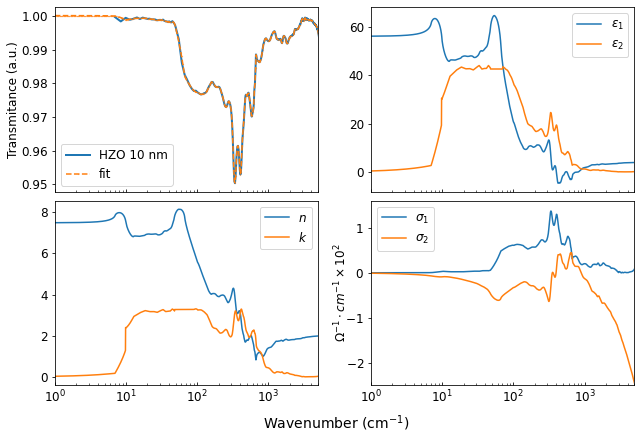

In [1068]:
plotting_optical_prop_noshift('HZO 10 nm', HZO_10_data, HZO_10_fit, HZO_10_epsilon, HZO_10_N, HZO_10_sigma)

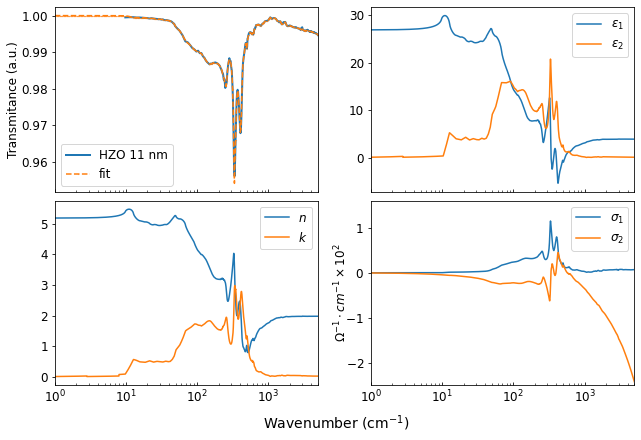

In [1072]:
plotting_optical_prop('HZO 11 nm', HZO_11_data, HZO_11_fit, HZO_11_epsilon, HZO_11_N, HZO_11_sigma, shift_multiply_epsilon=1.2, 
                      shift_multiply_N=1, shift_sum_E=-2, shift_sum_N=0, 
                      start_E2=498,  
                      stop_E2=1120,
                      start2_E2=0,
                      stop2_E2=220)

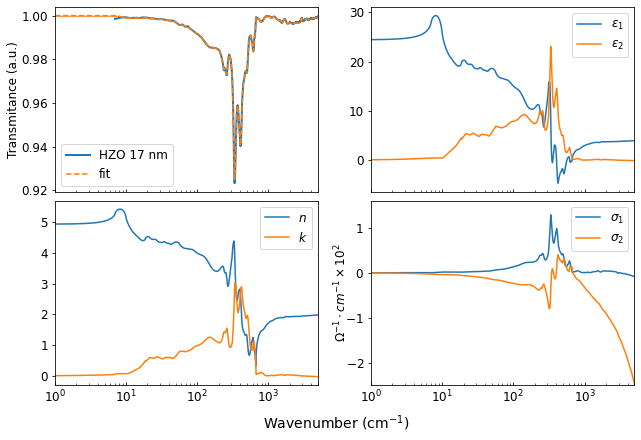

In [1066]:
plotting_optical_prop_noshift('HZO 17 nm', HZO_17_data, HZO_17_fit, HZO_17_epsilon, HZO_17_N, HZO_17_sigma)

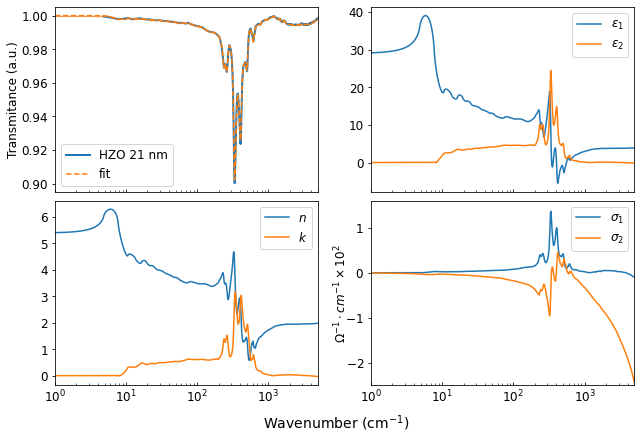

In [1069]:
plotting_optical_prop('HZO 21 nm', HZO_21_data, HZO_21_fit, HZO_21_epsilon, HZO_21_N, HZO_21_sigma)

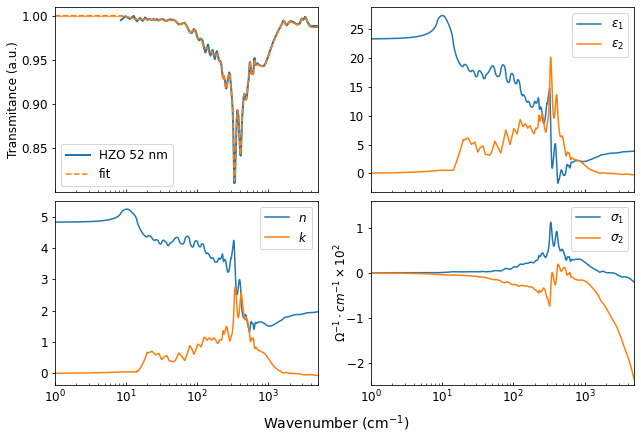

In [1064]:
plotting_optical_prop_noshift('HZO 52 nm', data, HZO_52_fit, HZO_52_epsilon, HZO_52_N, HZO_52_sigma)

### Plotting all E1 together to check Estatic

In [1160]:
import matplotlib.pyplot as plt

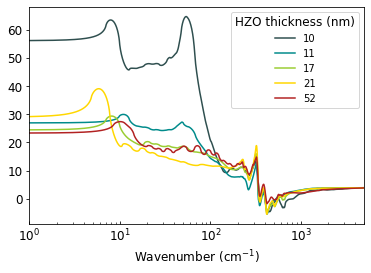

In [1163]:
E1_all = {'10': HZO_10_epsilon,
          '11': HZO_11_epsilon,
          '17': HZO_17_epsilon,
          '21': HZO_21_epsilon,
          '52': HZO_52_epsilon    
}

fig, ax = plt.subplots()

colours = ['darkslategray', 'darkcyan', 'yellowgreen', 'gold', 'firebrick']

for i, colour in zip(E1_all.keys(), colours):
    ax.plot(E1_all[i].Frequency, E1_all[i].E1, label=i, c=colour)

ax.set_xscale(value='log')
ax.legend(title='HZO thickness (nm)', fontsize=10)
ax.tick_params(axis='x', direction='in', which='both')
ax.set_xlabel('Wavenumber (cm$^{-1}$)')
ax.set_xlim(1, 5000)

plt.rcParams.update({'font.size': 12})

fig.savefig("E1_all.png", bbox_inches="tight")

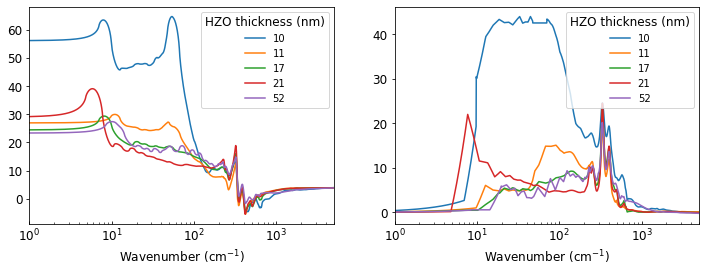

In [1098]:
E_all = {'10': HZO_10_epsilon,
          '11': HZO_11_epsilon,
          '17': HZO_17_epsilon,
          '21': HZO_21_epsilon,
          '52': HZO_52_epsilon    
}

fig, axs = plt.subplots(1,2)

for i, j in zip(E_all.keys(), E_all.keys()):
    axs[0].plot(E_all[i].Frequency, E_all[i].E1, label=i)
    axs[1].plot(E_all[i].Frequency, E_all[i].E2, label=i)

for ax in axs.flat:
    ax.set_xscale(value='log')
    ax.legend(title='HZO thickness (nm)', fontsize=10)
    ax.tick_params(axis='x', direction='in', which='both')
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax.set_xlim(1, 5000)

fig.set_size_inches(12,4)
# fig.savefig("E_all.png", bbox_inches="tight")

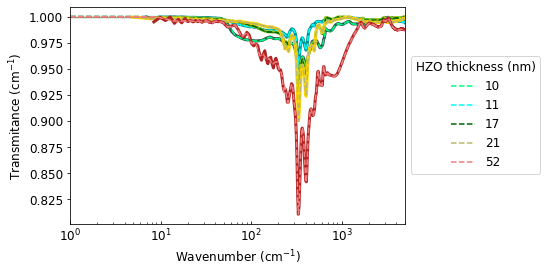

In [1164]:
data_all = {'10': HZO_10_data,
          '11': HZO_11_data,
          '17': HZO_17_data,
          '21': HZO_21_data,
          '52': data    
}

fit_all = {'10': HZO_10_fit,
          '11': HZO_11_fit,
          '17': HZO_17_fit,
          '21': HZO_21_fit,
          '52': HZO_52_fit    
}

fig, ax = plt.subplots()

colours = ['darkslategray', 'darkcyan', 'yellowgreen', 'gold', 'firebrick']
colours_fit =  ['springgreen', 'cyan', 'darkgreen', 'darkkhaki', 'lightcoral']

for i, j, colour, colour_f in zip(data_all.keys(), fit_all.keys(), colours, colours_fit):
    
    ax.plot(data_all[i].Frequency, data_all[i].Transmitance, linewidth=3, c=colour)
    ax.plot(fit_all[i].Frequency, fit_all[i].Transmitance, linestyle='dashed', marker='.', markersize=0.1, 
            c=colour_f, label=i)

ax.set_xscale(value='log')
ax.legend(title='HZO thickness (nm)', fontsize=12, bbox_to_anchor=(1,0.8))
ax.tick_params(axis='x', direction='in', which='both')
ax.set_xlabel('Wavenumber (cm$^{-1}$)')
ax.set_ylabel('Transmitance (cm$^{-1}$)')
ax.set_xlim(1, 5000)

fig.savefig("data_fit_all_big_zone.png", bbox_inches="tight")

In [1127]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

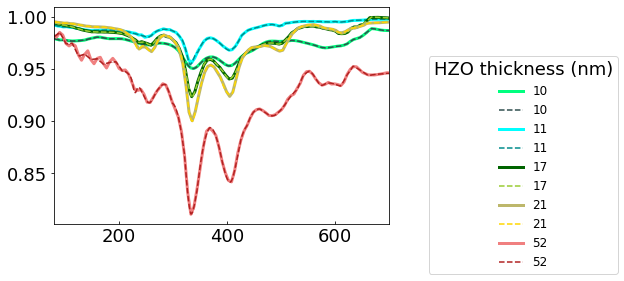

In [1155]:
data_all = {'10': HZO_10_data,
          '11': HZO_11_data,
          '17': HZO_17_data,
          '21': HZO_21_data,
          '52': data    
}

fit_all = {'10': HZO_10_fit,
          '11': HZO_11_fit,
          '17': HZO_17_fit,
          '21': HZO_21_fit,
          '52': HZO_52_fit    
}

fig, ax = plt.subplots()

colours = ['springgreen', 'cyan', 'darkgreen', 'darkkhaki', 'lightcoral']
colours_fit = ['darkslategray', 'darkcyan', 'yellowgreen', 'gold', 'firebrick']

for i, j, colour, colour_f in zip(data_all.keys(), fit_all.keys(), colours, colours_fit):
    
    ax.plot(data_all[i].Frequency, data_all[i].Transmitance, linewidth=3, c=colour, label=i)
    ax.plot(fit_all[i].Frequency, fit_all[i].Transmitance, linestyle='dashed', marker='.', markersize=0.1, 
            c=colour_f, label=i )

# ax.set_xscale(value='log')
ax.legend(title='HZO thickness (nm)', fontsize=12, bbox_to_anchor=(1.1,0.8))


ax.tick_params(axis='x', direction='in', which='both')
ax.set_xlim(80, 700)
# plt.rcParams.update({'font.size': 18})

fig.savefig("data_fit_all.png", bbox_inches="tight")